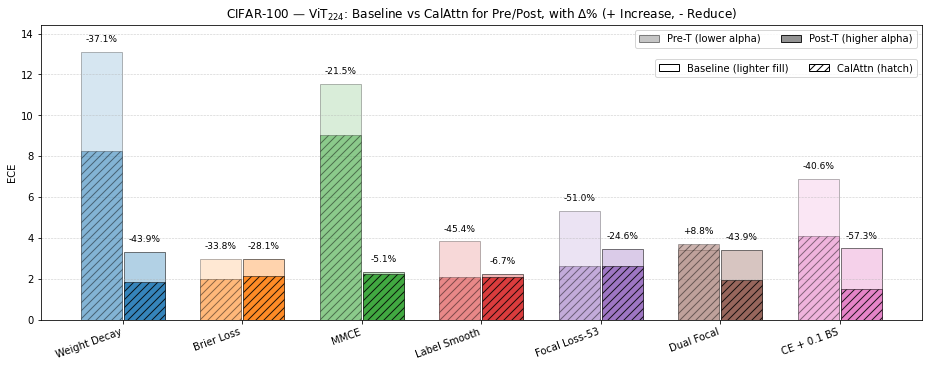

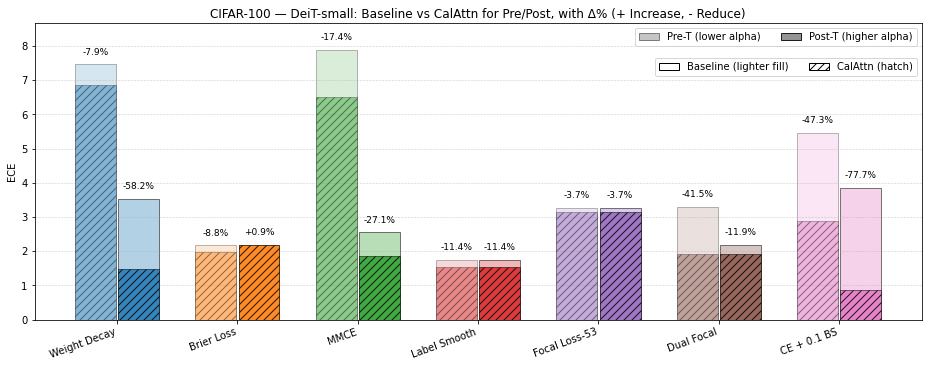

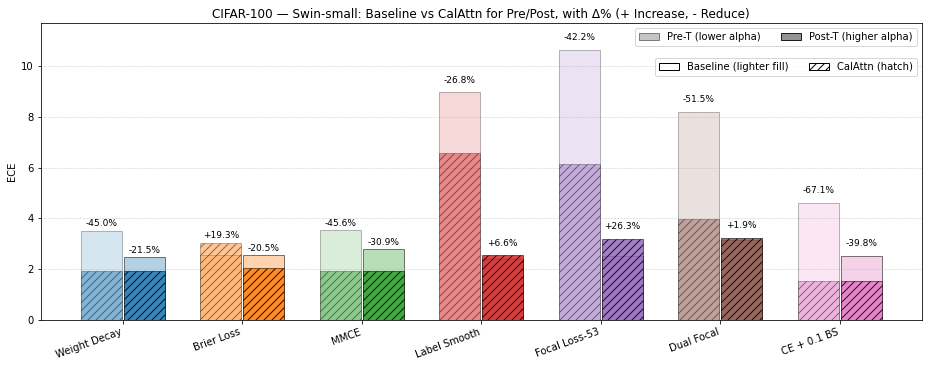

{'ViT$_{224}$': '../../outputs/plotSave/cifar100_compare_baseline_vs_calattn_prepost_delta_vit224.png',
 'DeiT-small': '../../outputs/plotSave/cifar100_compare_baseline_vs_calattn_prepost_delta_deitsmall.png',
 'Swin-small': '../../outputs/plotSave/cifar100_compare_baseline_vs_calattn_prepost_delta_swinsmall.png'}

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import colors as mcolors

# -------------------------
# CIFAR-100 data (from user)
# -------------------------
methods = [
    "Weight Decay",
    "Brier Loss",
    "MMCE",
    "Label Smooth",
    "Focal Loss-53",
    "Dual Focal",
    # r"CE + $\lambda$ BS ($\lambda$=0.1)"
    r"CE + 0.1 BS"
]
import numpy as np

def _bbox_overlap(a, b):
    """Return overlap area between two bboxes (in display coords)."""
    x0 = max(a.x0, b.x0)
    y0 = max(a.y0, b.y0)
    x1 = min(a.x1, b.x1)
    y1 = min(a.y1, b.y1)
    if x1 <= x0 or y1 <= y0:
        return 0.0
    return (x1 - x0) * (y1 - y0)

def place_legend_no_overlap(ax, handles, labels, *,
                            title="Loss / Method (color)",
                            ncol=2,
                            fontsize=9,
                            title_fontsize=9,
                            pad=2.0):
    """
    Place legend inside axes by searching candidate locations and minimizing overlap with bars.
    Assumes bar patches are in ax.patches.
    """
    fig = ax.figure

    # Candidate legend anchor points in axes fraction coords (x,y)
    # You can add/remove points if you like.
    candidates = [
        (0.02, 0.98, "upper left"),
        (0.50, 0.98, "upper center"),
        (0.98, 0.98, "upper right"),
        (0.02, 0.70, "upper left"),
        (0.98, 0.70, "upper right"),
        (0.02, 0.02, "lower left"),
        (0.50, 0.02, "lower center"),
        (0.98, 0.02, "lower right"),
    ]

    # Get bar bboxes in display coords
    renderer = fig.canvas.get_renderer()
    bar_bboxes = []
    for p in ax.patches:
        try:
            bb = p.get_window_extent(renderer=renderer).expanded(1.02, 1.02)
            bar_bboxes.append(bb)
        except Exception:
            pass

    best = None
    best_leg = None

    # Try each candidate position
    for (x, y, loc) in candidates:
        leg = ax.legend(
            handles=handles,
            labels=labels,
            title=title,
            ncol=ncol,
            loc=loc,
            bbox_to_anchor=(x, y),
            bbox_transform=ax.transAxes,
            frameon=True,
            fontsize=fontsize,
            title_fontsize=title_fontsize,
            borderaxespad=0.0,
            handlelength=1.2,
            labelspacing=0.4,
            columnspacing=0.8,
        )
        fig.canvas.draw()  # needed to get legend bbox

        leg_bb = leg.get_window_extent(renderer=renderer).expanded(1.0, 1.0)

        # overlap score: sum of overlap areas with all bars
        overlap = 0.0
        for bb in bar_bboxes:
            overlap += _bbox_overlap(leg_bb, bb)

        # also penalize if legend falls outside axes area (rare but possible)
        ax_bb = ax.get_window_extent(renderer=renderer)
        outside = _bbox_overlap(leg_bb, ax_bb)
        outside_penalty = 0.0 if outside > 0 else 1e18

        score = overlap + outside_penalty

        if best is None or score < best:
            best = score
            best_leg = leg
        else:
            leg.remove()

        # Early exit if perfect (no overlap)
        if best == 0.0:
            break

    return best_leg

c100_rows = [
    ("ViT$_{224}$", "Baseline",
     [13.11, "3.30(1.30)", 2.99, "2.99(1.00)", 11.52, "2.34(1.30)", 3.83, "2.24(1.10)", 5.33, "3.46(1.10)", 3.42, "3.42(1.00)", 6.89, "3.49(1.50)"]),
    ("ViT$_{224}$", "CalAttn (Ours)",
     [8.25, "1.85(1.20)", 1.98, "2.15(1.10)", 9.04, "2.22(1.20)", 2.09, "2.09(1.00)", 2.61, "2.61(1.00)", 3.72, "1.92(1.10)", 4.09, "1.49(1.10)"]),
    ("DeiT-small", "Baseline",
     [7.46, "3.54(1.10)", 2.17, "2.17(1.00)", 7.88, "2.55(1.20)", 1.75, "1.75(1.00)", 3.27, "3.27(1.00)", 3.30, "2.19(1.10)", 5.46, "3.86(1.40)"]),
    ("DeiT-small", "CalAttn (Ours)",
     [6.87, "1.48(1.20)", 1.98, "2.19(1.10)", 6.51, "1.86(1.20)", 1.55, "1.55(1.00)", 3.15, "3.15(1.00)", 1.93, "1.93(1.00)", 2.88, "0.86(1.10)"]),
    ("Swin-small", "Baseline",
     [3.51, "2.46(0.90)", 2.54, "2.54(1.00)", 3.53, "2.78(0.90)", 9.00, "2.41(0.80)", 10.64, "2.51(0.80)", 8.18, "3.15(0.80)", 4.59, "2.51(1.20)"]),
    ("Swin-small", "CalAttn (Ours)",
     [1.93, "1.93(1.00)", 3.03, "2.02(1.10)", 1.92, "1.92(1.00)", 6.59, "2.57(0.90)", 6.15, "3.17(0.90)", 3.97, "3.21(0.90)", 1.51, "1.51(1.00)"]),
]

def parse_post_value(x):
    if isinstance(x, (int, float)):
        return float(x)
    m = re.match(r"\s*([0-9]*\.?[0-9]+)\s*(?:\(([^)]*)\))?\s*$", str(x))
    if not m:
        raise ValueError(f"Cannot parse: {x}")
    return float(m.group(1))

data = []
for arch, variant, vals in c100_rows:
    for i, method in enumerate(methods):
        pre = float(vals[2*i])
        post = parse_post_value(vals[2*i + 1])
        data.append({"Architecture": arch, "Variant": variant, "Method": method, "Pre-T": pre, "Post-T": post})
df100 = pd.DataFrame(data)

# Colors: one hue per method
tab10 = plt.get_cmap("tab10").colors
method_colors = {m: tab10[i % len(tab10)] for i, m in enumerate(methods)}

def lighten(color, amount=0.60):
    c = np.array(mcolors.to_rgb(color))
    return tuple(c + (1 - c) * amount)

def plot_compare_calattn_vs_baseline_prepost(arch, outfile):
    base = df100[(df100["Architecture"] == arch) & (df100["Variant"] == "Baseline")].copy()
    cal  = df100[(df100["Architecture"] == arch) & (df100["Variant"] == "CalAttn (Ours)")].copy()

    base["Method"] = pd.Categorical(base["Method"], categories=methods, ordered=True)
    cal["Method"]  = pd.Categorical(cal["Method"],  categories=methods, ordered=True)
    base = base.sort_values("Method")
    cal  = cal.sort_values("Method")

    x = np.arange(len(methods))
    dx = 0.18
    w = 0.34  # same width for all bars
    stage_alpha = {"Pre-T": 0.45, "Post-T": 0.85}

    plt.figure(figsize=(13.0, 5.2))
    ax = plt.gca()

    ymax = 0.0
    for i, m in enumerate(methods):
        col = method_colors[m]
        b_pre  = float(base[base["Method"] == m]["Pre-T"].iloc[0])
        b_post = float(base[base["Method"] == m]["Post-T"].iloc[0])
        c_pre  = float(cal[cal["Method"] == m]["Pre-T"].iloc[0])
        c_post = float(cal[cal["Method"] == m]["Post-T"].iloc[0])
        ymax = max(ymax, b_pre, b_post, c_pre, c_post)

        pre_pos = x[i] - dx
        post_pos = x[i] + dx

        # PRE: overlay baseline then calattn (same width)
        ax.bar(pre_pos, b_pre,  width=w, color=lighten(col), alpha=stage_alpha["Pre-T"],
               edgecolor="black", linewidth=0.6, zorder=1)
        ax.bar(pre_pos, c_pre,  width=w, color=col, alpha=stage_alpha["Pre-T"],
               edgecolor="black", linewidth=0.6, hatch="///", zorder=2)

        # POST: overlay baseline then calattn (same width)
        ax.bar(post_pos, b_post, width=w, color=lighten(col), alpha=stage_alpha["Post-T"],
               edgecolor="black", linewidth=0.6, zorder=1)
        ax.bar(post_pos, c_post, width=w, color=col, alpha=stage_alpha["Post-T"],
               edgecolor="black", linewidth=0.6, hatch="///", zorder=2)

        # Δ% labels (CalAttn vs Baseline), one for pre and one for post
        dpre  = (c_pre  - b_pre)  / b_pre  * 100.0 if b_pre  != 0 else np.nan
        dpost = (c_post - b_post) / b_post * 100.0 if b_post != 0 else np.nan
        ax.text(pre_pos,  max(b_pre,  c_pre)  + 0.03*ymax, f"{dpre:+.1f}%",
                ha="center", va="bottom", fontsize=9)
        ax.text(post_pos, max(b_post, c_post) + 0.03*ymax, f"{dpost:+.1f}%",
                ha="center", va="bottom", fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=20, ha="right")
    ax.set_ylabel("ECE")
    ax.set_title(f"CIFAR-100 — {arch}: Baseline vs CalAttn for Pre/Post, with Δ% (+ Increase, - Reduce)")
    ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)
    ax.set_ylim(0, ymax * 1.1)

    method_legend = [Patch(facecolor=method_colors[m], edgecolor="black", label=m) for m in methods]

    # handles = method_legend
    # labels = [h.get_label() for h in handles]
    # leg1 = place_legend_no_overlap(ax, handles, labels, ncol=2)
    # ax.add_artist(leg1)



    variant_legend = [
        Patch(facecolor="white", edgecolor="black", hatch="", label="Baseline (lighter fill)"),
        Patch(facecolor="white", edgecolor="black", hatch="///", label="CalAttn (hatch)"),
    ]
    leg2 = ax.legend(handles=variant_legend, ncol=2,
                     loc="upper right", bbox_to_anchor=(1.0, 0.9), frameon=True)
    ax.add_artist(leg2)

    stage_legend = [
        Patch(facecolor="gray", edgecolor="black", alpha=stage_alpha["Pre-T"], label="Pre-T (lower alpha)"),
        Patch(facecolor="gray", edgecolor="black", alpha=stage_alpha["Post-T"], label="Post-T (higher alpha)"),
    ]
    ax.legend(handles=stage_legend, ncol=2,
              loc="upper right", bbox_to_anchor=(1.0, 1.0), frameon=True)

    plt.tight_layout()
    plt.savefig(outfile, dpi=220, bbox_inches="tight")
    plt.show()

out_compare = {}
for arch in ["ViT$_{224}$", "DeiT-small", "Swin-small"]:
    safe_arch = arch.replace("$","").replace("{","").replace("}","").replace("_","").replace("\\","").replace(" ","").replace("-","").lower()
    path = f"../../outputs/plotSave/cifar100_compare_baseline_vs_calattn_prepost_delta_{safe_arch}.png"
    out_compare[arch] = path
    plot_compare_calattn_vs_baseline_prepost(arch, path)

out_compare



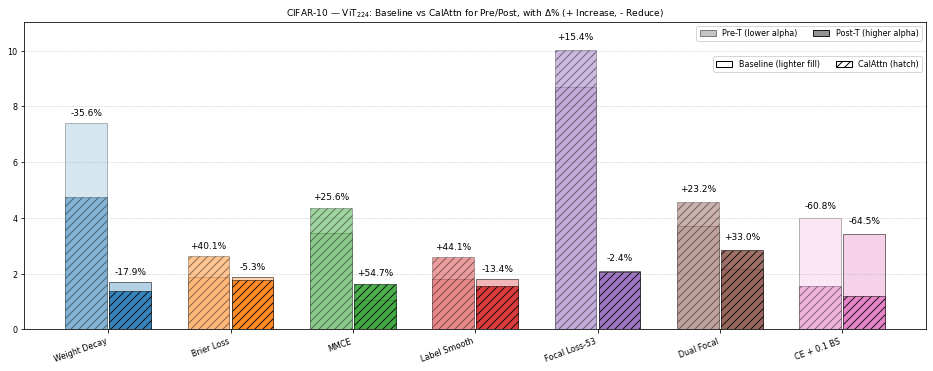

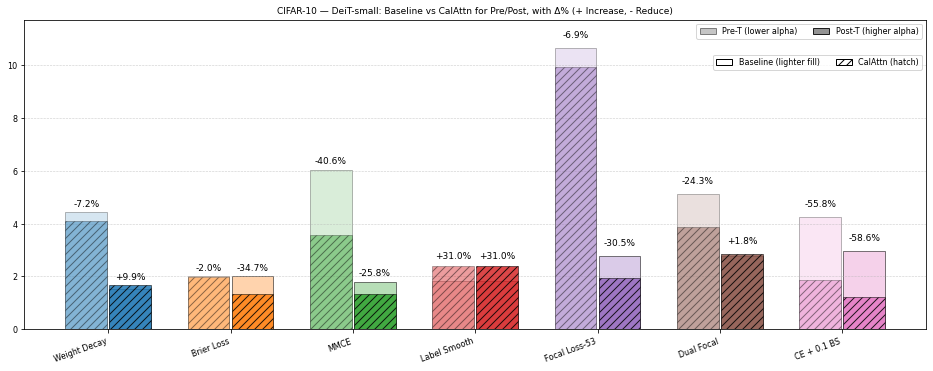

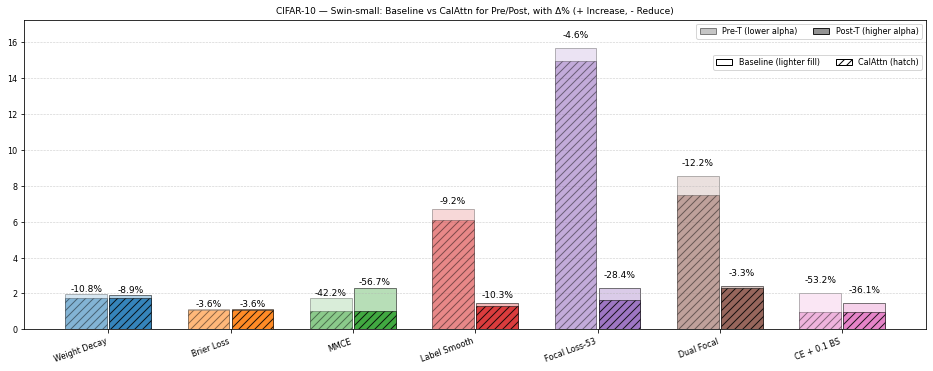

{'ViT$_{224}$': '../../outputs/plotSave/cifar10_compare_baseline_vs_calattn_prepost_delta_vit224.png',
 'DeiT-small': '../../outputs/plotSave/cifar10_compare_baseline_vs_calattn_prepost_delta_deitsmall.png',
 'Swin-small': '../../outputs/plotSave/cifar10_compare_baseline_vs_calattn_prepost_delta_swinsmall.png'}

In [34]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import colors as mcolors

# -------------------------
# CIFAR-100 data (from user)
# -------------------------
methods = [
    "Weight Decay",
    "Brier Loss",
    "MMCE",
    "Label Smooth",
    "Focal Loss-53",
    "Dual Focal",
    # r"CE + $\lambda$ BS ($\lambda$=0.1)"
    r"CE + 0.1 BS"
]
import numpy as np

def _bbox_overlap(a, b):
    """Return overlap area between two bboxes (in display coords)."""
    x0 = max(a.x0, b.x0)
    y0 = max(a.y0, b.y0)
    x1 = min(a.x1, b.x1)
    y1 = min(a.y1, b.y1)
    if x1 <= x0 or y1 <= y0:
        return 0.0
    return (x1 - x0) * (y1 - y0)

def place_legend_no_overlap(ax, handles, labels, *,
                            title="Loss / Method (color)",
                            ncol=2,
                            fontsize=9,
                            title_fontsize=9,
                            pad=2.0):
    """
    Place legend inside axes by searching candidate locations and minimizing overlap with bars.
    Assumes bar patches are in ax.patches.
    """
    fig = ax.figure

    # Candidate legend anchor points in axes fraction coords (x,y)
    # You can add/remove points if you like.
    candidates = [
        (0.02, 0.98, "upper left"),
        (0.50, 0.98, "upper center"),
        (0.98, 0.98, "upper right"),
        (0.02, 0.70, "upper left"),
        (0.98, 0.70, "upper right"),
        (0.02, 0.02, "lower left"),
        (0.50, 0.02, "lower center"),
        (0.98, 0.02, "lower right"),
    ]

    # Get bar bboxes in display coords
    renderer = fig.canvas.get_renderer()
    bar_bboxes = []
    for p in ax.patches:
        try:
            bb = p.get_window_extent(renderer=renderer).expanded(1.02, 1.02)
            bar_bboxes.append(bb)
        except Exception:
            pass

    best = None
    best_leg = None

    # Try each candidate position
    for (x, y, loc) in candidates:
        leg = ax.legend(
            handles=handles,
            labels=labels,
            title=title,
            ncol=ncol,
            loc=loc,
            bbox_to_anchor=(x, y),
            bbox_transform=ax.transAxes,
            frameon=True,
            fontsize=fontsize,
            title_fontsize=title_fontsize,
            borderaxespad=0.0,
            handlelength=1.2,
            labelspacing=0.4,
            columnspacing=0.8,
        )
        fig.canvas.draw()  # needed to get legend bbox

        leg_bb = leg.get_window_extent(renderer=renderer).expanded(1.0, 1.0)

        # overlap score: sum of overlap areas with all bars
        overlap = 0.0
        for bb in bar_bboxes:
            overlap += _bbox_overlap(leg_bb, bb)

        # also penalize if legend falls outside axes area (rare but possible)
        ax_bb = ax.get_window_extent(renderer=renderer)
        outside = _bbox_overlap(leg_bb, ax_bb)
        outside_penalty = 0.0 if outside > 0 else 1e18

        score = overlap + outside_penalty

        if best is None or score < best:
            best = score
            best_leg = leg
        else:
            leg.remove()

        # Early exit if perfect (no overlap)
        if best == 0.0:
            break

    return best_leg

c10_rows = [
    ("ViT$_{224}$", "Baseline",
     [7.39, "1.68(1.30)",
      1.87, "1.87(1.00)",
      3.47, "1.06(1.10)",
      1.79, "1.79(1.00)",
      8.70, "2.11(0.70)",
      3.71, "2.15(0.90)",
      3.98, "3.41(1.40)"]),

    ("ViT$_{224}$", "CalAttn (Ours)",
     [4.76, "1.38(1.20)",
      2.62, "1.77(1.10)",
      4.36, "1.64(1.20)",
      2.58, "1.55(0.90)",
      10.04, "2.06(0.70)",
      4.57, "2.86(0.90)",
      1.56, "1.21(1.10)"]),

    ("DeiT-small", "Baseline",
     [4.42, "1.52(1.20)",
      2.02, "2.02(1.00)",
      6.01, "1.78(1.20)",
      1.84, "1.84(1.00)",
      10.65, "2.79(0.70)",
      5.11, "2.79(0.80)",
      4.25, "2.95(1.30)"]),

    ("DeiT-small", "CalAttn (Ours)",
     [4.10, "1.67(1.10)",
      1.98, "1.32(1.10)",
      3.57, "1.32(1.10)",
      2.41, "2.41(1.00)",
      9.91, "1.94(0.70)",
      3.87, "2.84(0.90)",
      1.88, "1.22(1.10)"]),

    ("Swin-small", "Baseline",
     [1.95, "1.91(0.90)",
      1.12, "1.12(1.00)",
      1.73, "2.31(0.90)",
      6.71, "1.45(0.80)",
      15.70, "2.32(0.60)",
      8.54, "2.40(0.70)",
      2.01, "1.47(1.20)"]),

    ("Swin-small", "CalAttn (Ours)",
     [1.74, "1.74(1.00)",
      1.08, "1.08(1.00)",
      1.00, "1.00(1.00)",
      6.09, "1.30(0.80)",
      14.97, "1.66(0.60)",
      7.50, "2.32(0.80)",
      0.94, "0.94(1.00)"]),
]


def parse_post_value(x):
    if isinstance(x, (int, float)):
        return float(x)
    m = re.match(r"\s*([0-9]*\.?[0-9]+)\s*(?:\(([^)]*)\))?\s*$", str(x))
    if not m:
        raise ValueError(f"Cannot parse: {x}")
    return float(m.group(1))

data = []
for arch, variant, vals in c10_rows:
    for i, method in enumerate(methods):
        pre = float(vals[2*i])
        post = parse_post_value(vals[2*i + 1])
        data.append({"Architecture": arch, "Variant": variant, "Method": method, "Pre-T": pre, "Post-T": post})
df100 = pd.DataFrame(data)

# Colors: one hue per method
tab10 = plt.get_cmap("tab10").colors
method_colors = {m: tab10[i % len(tab10)] for i, m in enumerate(methods)}

def lighten(color, amount=0.60):
    c = np.array(mcolors.to_rgb(color))
    return tuple(c + (1 - c) * amount)

def plot_compare_calattn_vs_baseline_prepost(arch, outfile):
    base = df100[(df100["Architecture"] == arch) & (df100["Variant"] == "Baseline")].copy()
    cal  = df100[(df100["Architecture"] == arch) & (df100["Variant"] == "CalAttn (Ours)")].copy()

    base["Method"] = pd.Categorical(base["Method"], categories=methods, ordered=True)
    cal["Method"]  = pd.Categorical(cal["Method"],  categories=methods, ordered=True)
    base = base.sort_values("Method")
    cal  = cal.sort_values("Method")

    x = np.arange(len(methods))
    dx = 0.18
    w = 0.34  # same width for all bars
    stage_alpha = {"Pre-T": 0.45, "Post-T": 0.85}

    plt.figure(figsize=(13.0, 5.2))
    ax = plt.gca()

    ymax = 0.0
    for i, m in enumerate(methods):
        col = method_colors[m]
        b_pre  = float(base[base["Method"] == m]["Pre-T"].iloc[0])
        b_post = float(base[base["Method"] == m]["Post-T"].iloc[0])
        c_pre  = float(cal[cal["Method"] == m]["Pre-T"].iloc[0])
        c_post = float(cal[cal["Method"] == m]["Post-T"].iloc[0])
        ymax = max(ymax, b_pre, b_post, c_pre, c_post)

        pre_pos = x[i] - dx
        post_pos = x[i] + dx

        # PRE: overlay baseline then calattn (same width)
        ax.bar(pre_pos, b_pre,  width=w, color=lighten(col), alpha=stage_alpha["Pre-T"],
               edgecolor="black", linewidth=0.6, zorder=1)
        ax.bar(pre_pos, c_pre,  width=w, color=col, alpha=stage_alpha["Pre-T"],
               edgecolor="black", linewidth=0.6, hatch="///", zorder=2)

        # POST: overlay baseline then calattn (same width)
        ax.bar(post_pos, b_post, width=w, color=lighten(col), alpha=stage_alpha["Post-T"],
               edgecolor="black", linewidth=0.6, zorder=1)
        ax.bar(post_pos, c_post, width=w, color=col, alpha=stage_alpha["Post-T"],
               edgecolor="black", linewidth=0.6, hatch="///", zorder=2)

        # Δ% labels (CalAttn vs Baseline), one for pre and one for post
        dpre  = (c_pre  - b_pre)  / b_pre  * 100.0 if b_pre  != 0 else np.nan
        dpost = (c_post - b_post) / b_post * 100.0 if b_post != 0 else np.nan
        ax.text(pre_pos,  max(b_pre,  c_pre)  + 0.03*ymax, f"{dpre:+.1f}%",
                ha="center", va="bottom", fontsize=9)
        ax.text(post_pos, max(b_post, c_post) + 0.03*ymax, f"{dpost:+.1f}%",
                ha="center", va="bottom", fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=20, ha="right")
    # ax.set_ylabel("ECE")
    ax.set_title(f"CIFAR-10 — {arch}: Baseline vs CalAttn for Pre/Post, with Δ% (+ Increase, - Reduce)")
    ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)
    ax.set_ylim(0, ymax * 1.1)

    method_legend = [Patch(facecolor=method_colors[m], edgecolor="black", label=m) for m in methods]

    # handles = method_legend
    # labels = [h.get_label() for h in handles]
    # leg1 = place_legend_no_overlap(ax, handles, labels, ncol=2)
    # ax.add_artist(leg1)



    variant_legend = [
        Patch(facecolor="white", edgecolor="black", hatch="", label="Baseline (lighter fill)"),
        Patch(facecolor="white", edgecolor="black", hatch="///", label="CalAttn (hatch)"),
    ]
    leg2 = ax.legend(handles=variant_legend, ncol=2,
                     loc="upper right", bbox_to_anchor=(1.0, 0.9), frameon=True)
    ax.add_artist(leg2)

    stage_legend = [
        Patch(facecolor="gray", edgecolor="black", alpha=stage_alpha["Pre-T"], label="Pre-T (lower alpha)"),
        Patch(facecolor="gray", edgecolor="black", alpha=stage_alpha["Post-T"], label="Post-T (higher alpha)"),
    ]
    ax.legend(handles=stage_legend, ncol=2,
              loc="upper right", bbox_to_anchor=(1.0, 1.0), frameon=True)

    plt.tight_layout()
    plt.savefig(outfile, dpi=220, bbox_inches="tight")
    plt.show()

out_compare = {}
for arch in ["ViT$_{224}$", "DeiT-small", "Swin-small"]:
    safe_arch = arch.replace("$","").replace("{","").replace("}","").replace("_","").replace("\\","").replace(" ","").replace("-","").lower()
    path = f"../../outputs/plotSave/cifar10_compare_baseline_vs_calattn_prepost_delta_{safe_arch}.png"
    out_compare[arch] = path
    plot_compare_calattn_vs_baseline_prepost(arch, path)

out_compare



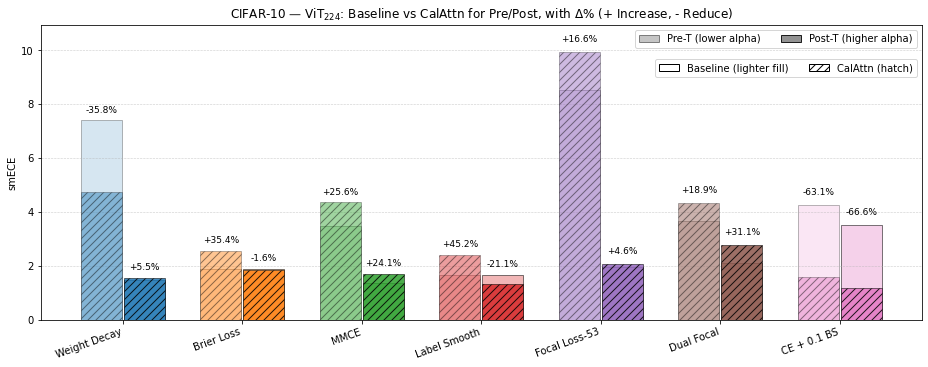

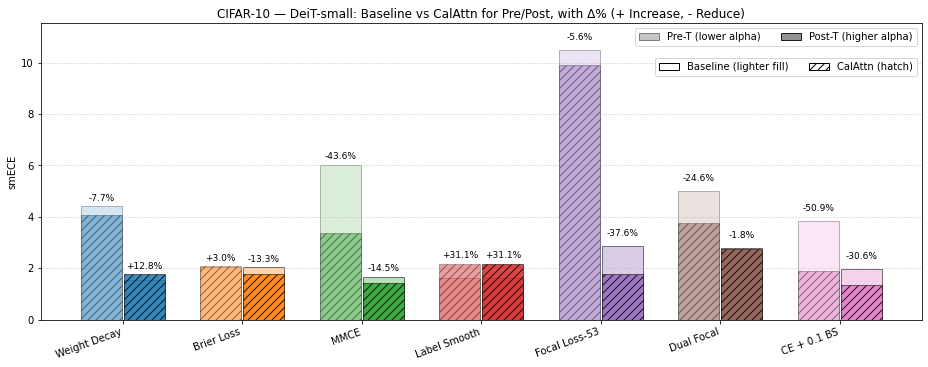

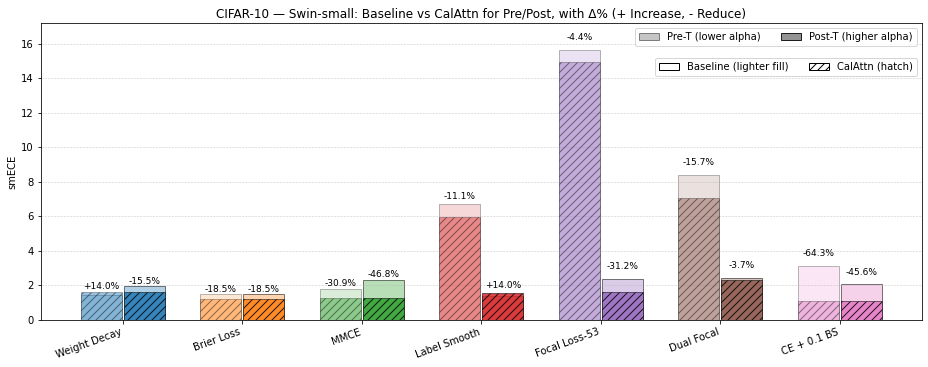

{'ViT$_{224}$': '../../outputs/plotSave/smECE_cifar10_compare_baseline_vs_calattn_prepost_delta_vit224.png',
 'DeiT-small': '../../outputs/plotSave/smECE_cifar10_compare_baseline_vs_calattn_prepost_delta_deitsmall.png',
 'Swin-small': '../../outputs/plotSave/smECE_cifar10_compare_baseline_vs_calattn_prepost_delta_swinsmall.png'}

In [30]:
# smECE — CIFAR-10
c10_rows = [
    ("ViT$_{224}$", "Baseline",
     [7.40, "1.46(1.30)",
      1.89, "1.89(1.00)",
      3.47, "1.37(1.10)",
      1.66, "1.66(1.00)",
      8.53, "1.97(0.70)",
      3.66, "2.12(0.90)",
      4.26, "3.53(1.40)"]),

    ("ViT$_{224}$", "CalAttn (Ours)",
     [4.75, "1.54(1.20)",
      2.56, "1.86(1.10)",
      4.36, "1.70(1.20)",
      2.41, "1.31(0.90)",
      9.95, "2.06(0.70)",
      4.35, "2.78(0.90)",
      1.57, "1.18(1.10)"]),

    ("DeiT-small", "Baseline",
     [4.41, "1.56(1.20)",
      2.03, "2.03(1.00)",
      6.01, "1.65(1.20)",
      1.64, "1.64(1.00)",
      10.49, "2.87(0.70)",
      5.00, "2.79(0.80)",
      3.85, "1.96(1.30)"]),

    ("DeiT-small", "CalAttn (Ours)",
     [4.07, "1.76(1.10)",
      2.09, "1.76(1.10)",
      3.39, "1.41(1.10)",
      2.15, "2.15(1.00)",
      9.90, "1.79(0.70)",
      3.77, "2.74(0.90)",
      1.89, "1.36(1.10)"]),

    ("Swin-small", "Baseline",
     [1.43, "1.93(0.90)",
      1.46, "1.46(1.00)",
      1.78, "2.31(0.90)",
      6.68, "1.36(0.80)",
      15.63, "2.34(0.60)",
      8.40, "2.41(0.70)",
      3.11, "2.04(1.20)"]),

    ("Swin-small", "CalAttn (Ours)",
     [1.63, "1.63(1.00)",
      1.19, "1.19(1.00)",
      1.23, "1.23(1.00)",
      5.94, "1.55(0.80)",
      14.94, "1.61(0.60)",
      7.08, "2.32(0.80)",
      1.11, "1.11(1.00)"]),
]



def parse_post_value(x):
    if isinstance(x, (int, float)):
        return float(x)
    m = re.match(r"\s*([0-9]*\.?[0-9]+)\s*(?:\(([^)]*)\))?\s*$", str(x))
    if not m:
        raise ValueError(f"Cannot parse: {x}")
    return float(m.group(1))

data = []
for arch, variant, vals in c10_rows:
    for i, method in enumerate(methods):
        pre = float(vals[2*i])
        post = parse_post_value(vals[2*i + 1])
        data.append({"Architecture": arch, "Variant": variant, "Method": method, "Pre-T": pre, "Post-T": post})
df100 = pd.DataFrame(data)

# Colors: one hue per method
tab10 = plt.get_cmap("tab10").colors
method_colors = {m: tab10[i % len(tab10)] for i, m in enumerate(methods)}

def lighten(color, amount=0.60):
    c = np.array(mcolors.to_rgb(color))
    return tuple(c + (1 - c) * amount)

def plot_compare_calattn_vs_baseline_prepost(arch, outfile):
    base = df100[(df100["Architecture"] == arch) & (df100["Variant"] == "Baseline")].copy()
    cal  = df100[(df100["Architecture"] == arch) & (df100["Variant"] == "CalAttn (Ours)")].copy()

    base["Method"] = pd.Categorical(base["Method"], categories=methods, ordered=True)
    cal["Method"]  = pd.Categorical(cal["Method"],  categories=methods, ordered=True)
    base = base.sort_values("Method")
    cal  = cal.sort_values("Method")

    x = np.arange(len(methods))
    dx = 0.18
    w = 0.34  # same width for all bars
    stage_alpha = {"Pre-T": 0.45, "Post-T": 0.85}

    plt.figure(figsize=(13.0, 5.2))
    ax = plt.gca()

    ymax = 0.0
    for i, m in enumerate(methods):
        col = method_colors[m]
        b_pre  = float(base[base["Method"] == m]["Pre-T"].iloc[0])
        b_post = float(base[base["Method"] == m]["Post-T"].iloc[0])
        c_pre  = float(cal[cal["Method"] == m]["Pre-T"].iloc[0])
        c_post = float(cal[cal["Method"] == m]["Post-T"].iloc[0])
        ymax = max(ymax, b_pre, b_post, c_pre, c_post)

        pre_pos = x[i] - dx
        post_pos = x[i] + dx

        # PRE: overlay baseline then calattn (same width)
        ax.bar(pre_pos, b_pre,  width=w, color=lighten(col), alpha=stage_alpha["Pre-T"],
               edgecolor="black", linewidth=0.6, zorder=1)
        ax.bar(pre_pos, c_pre,  width=w, color=col, alpha=stage_alpha["Pre-T"],
               edgecolor="black", linewidth=0.6, hatch="///", zorder=2)

        # POST: overlay baseline then calattn (same width)
        ax.bar(post_pos, b_post, width=w, color=lighten(col), alpha=stage_alpha["Post-T"],
               edgecolor="black", linewidth=0.6, zorder=1)
        ax.bar(post_pos, c_post, width=w, color=col, alpha=stage_alpha["Post-T"],
               edgecolor="black", linewidth=0.6, hatch="///", zorder=2)

        # Δ% labels (CalAttn vs Baseline), one for pre and one for post
        dpre  = (c_pre  - b_pre)  / b_pre  * 100.0 if b_pre  != 0 else np.nan
        dpost = (c_post - b_post) / b_post * 100.0 if b_post != 0 else np.nan
        ax.text(pre_pos,  max(b_pre,  c_pre)  + 0.03*ymax, f"{dpre:+.1f}%",
                ha="center", va="bottom", fontsize=9)
        ax.text(post_pos, max(b_post, c_post) + 0.03*ymax, f"{dpost:+.1f}%",
                ha="center", va="bottom", fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=20, ha="right")
    ax.set_ylabel("smECE")
    ax.set_title(f"CIFAR-10 — {arch}: Baseline vs CalAttn for Pre/Post, with Δ% (+ Increase, - Reduce)")
    ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)
    ax.set_ylim(0, ymax * 1.1)

    method_legend = [Patch(facecolor=method_colors[m], edgecolor="black", label=m) for m in methods]

    # handles = method_legend
    # labels = [h.get_label() for h in handles]
    # leg1 = place_legend_no_overlap(ax, handles, labels, ncol=2)
    # ax.add_artist(leg1)



    variant_legend = [
        Patch(facecolor="white", edgecolor="black", hatch="", label="Baseline (lighter fill)"),
        Patch(facecolor="white", edgecolor="black", hatch="///", label="CalAttn (hatch)"),
    ]
    leg2 = ax.legend(handles=variant_legend, ncol=2,
                     loc="upper right", bbox_to_anchor=(1.0, 0.9), frameon=True)
    ax.add_artist(leg2)

    stage_legend = [
        Patch(facecolor="gray", edgecolor="black", alpha=stage_alpha["Pre-T"], label="Pre-T (lower alpha)"),
        Patch(facecolor="gray", edgecolor="black", alpha=stage_alpha["Post-T"], label="Post-T (higher alpha)"),
    ]
    ax.legend(handles=stage_legend, ncol=2,
              loc="upper right", bbox_to_anchor=(1.0, 1.0), frameon=True)

    plt.tight_layout()
    plt.savefig(outfile, dpi=220, bbox_inches="tight")
    plt.show()

out_compare = {}
for arch in ["ViT$_{224}$", "DeiT-small", "Swin-small"]:
    safe_arch = arch.replace("$","").replace("{","").replace("}","").replace("_","").replace("\\","").replace(" ","").replace("-","").lower()
    path = f"../../outputs/plotSave/smECE_cifar10_compare_baseline_vs_calattn_prepost_delta_{safe_arch}.png"
    out_compare[arch] = path
    plot_compare_calattn_vs_baseline_prepost(arch, path)

out_compare

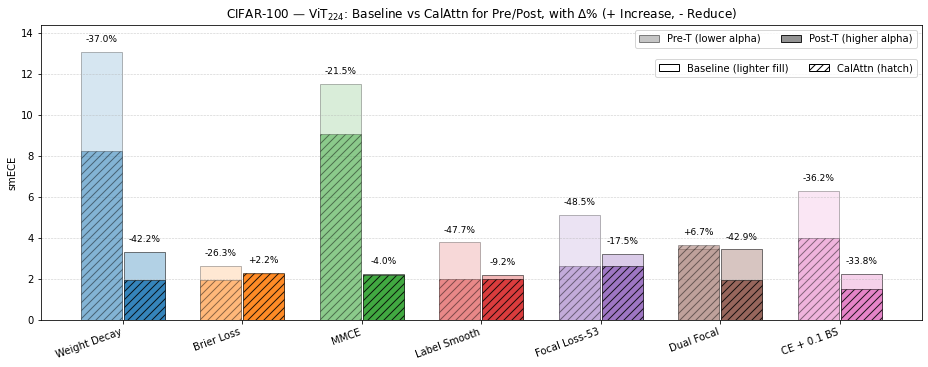

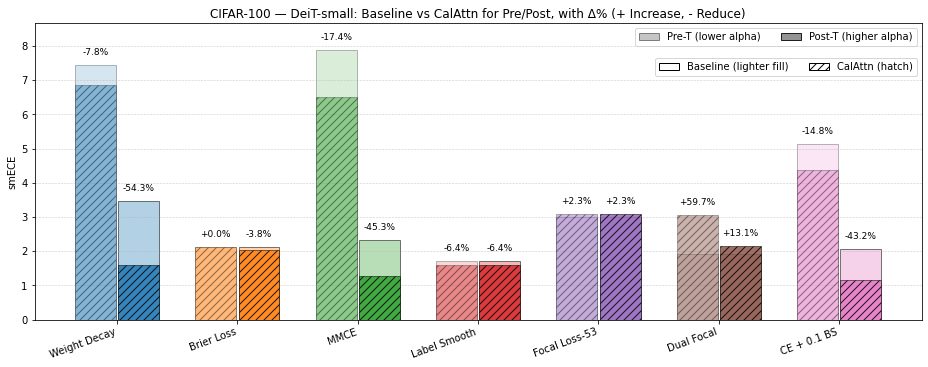

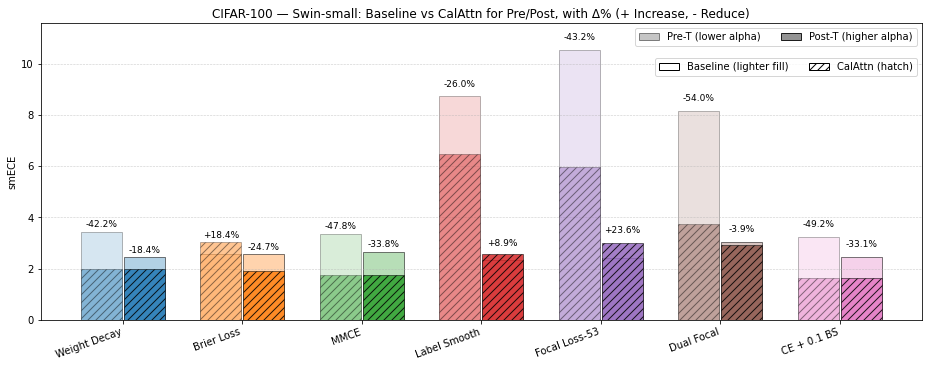

{'ViT$_{224}$': '../../outputs/plotSave/smECE_cifar100_compare_baseline_vs_calattn_prepost_delta_vit224.png',
 'DeiT-small': '../../outputs/plotSave/smECE_cifar100_compare_baseline_vs_calattn_prepost_delta_deitsmall.png',
 'Swin-small': '../../outputs/plotSave/smECE_cifar100_compare_baseline_vs_calattn_prepost_delta_swinsmall.png'}

In [31]:
# smECE — CIFAR-100
c100_rows = [
    ("ViT$_{224}$", "Baseline",
     [13.07, "3.32(1.30)",
      2.62, "2.25(1.10)",
      11.51, "2.25(1.30)",
      3.77, "2.17(1.10)",
      5.13, "3.20(1.10)",
      3.43, "3.43(1.00)",
      6.27, "2.25(1.50)"]),

    ("ViT$_{224}$", "CalAttn (Ours)",
     [8.24, "1.92(1.20)",
      1.93, "2.30(1.10)",
      9.04, "2.16(1.20)",
      1.97, "1.97(1.00)",
      2.64, "2.64(1.00)",
      3.66, "1.96(1.10)",
      4.00, "1.49(1.10)"]),

    ("DeiT-small", "Baseline",
     [7.45, "3.48(1.10)",
      2.13, "2.13(1.00)",
      7.88, "2.34(1.20)",
      1.72, "1.72(1.00)",
      3.01, "3.01(1.00)",
      1.91, "1.91(1.00)",
      5.13, "2.06(1.40)"]),

    ("DeiT-small", "CalAttn (Ours)",
     [6.87, "1.59(1.20)",
      2.13, "2.05(1.10)",
      6.51, "1.28(1.20)",
      1.61, "1.61(1.00)",
      3.08, "3.08(1.00)",
      3.05, "2.16(1.10)",
      4.37, "1.17(1.10)"]),

    ("Swin-small", "Baseline",
     [3.44, "2.44(0.90)",
      2.55, "2.55(1.00)",
      3.37, "2.66(0.90)",
      8.76, "2.35(0.80)",
      10.55, "2.42(0.80)",
      8.17, "3.04(0.80)",
      3.23, "2.45(1.20)"]),

    ("Swin-small", "CalAttn (Ours)",
     [1.99, "1.99(1.00)",
      3.02, "1.92(1.10)",
      1.76, "1.76(1.00)",
      6.48, "2.56(0.90)",
      5.99, "2.99(0.90)",
      3.76, "2.92(0.90)",
      1.64, "1.64(1.00)"]),
]


def parse_post_value(x):
    if isinstance(x, (int, float)):
        return float(x)
    m = re.match(r"\s*([0-9]*\.?[0-9]+)\s*(?:\(([^)]*)\))?\s*$", str(x))
    if not m:
        raise ValueError(f"Cannot parse: {x}")
    return float(m.group(1))

data = []
for arch, variant, vals in c100_rows:
    for i, method in enumerate(methods):
        pre = float(vals[2*i])
        post = parse_post_value(vals[2*i + 1])
        data.append({"Architecture": arch, "Variant": variant, "Method": method, "Pre-T": pre, "Post-T": post})
df100 = pd.DataFrame(data)

# Colors: one hue per method
tab10 = plt.get_cmap("tab10").colors
method_colors = {m: tab10[i % len(tab10)] for i, m in enumerate(methods)}

def lighten(color, amount=0.60):
    c = np.array(mcolors.to_rgb(color))
    return tuple(c + (1 - c) * amount)

def plot_compare_calattn_vs_baseline_prepost(arch, outfile):
    base = df100[(df100["Architecture"] == arch) & (df100["Variant"] == "Baseline")].copy()
    cal  = df100[(df100["Architecture"] == arch) & (df100["Variant"] == "CalAttn (Ours)")].copy()

    base["Method"] = pd.Categorical(base["Method"], categories=methods, ordered=True)
    cal["Method"]  = pd.Categorical(cal["Method"],  categories=methods, ordered=True)
    base = base.sort_values("Method")
    cal  = cal.sort_values("Method")

    x = np.arange(len(methods))
    dx = 0.18
    w = 0.34  # same width for all bars
    stage_alpha = {"Pre-T": 0.45, "Post-T": 0.85}

    plt.figure(figsize=(13.0, 5.2))
    ax = plt.gca()

    ymax = 0.0
    for i, m in enumerate(methods):
        col = method_colors[m]
        b_pre  = float(base[base["Method"] == m]["Pre-T"].iloc[0])
        b_post = float(base[base["Method"] == m]["Post-T"].iloc[0])
        c_pre  = float(cal[cal["Method"] == m]["Pre-T"].iloc[0])
        c_post = float(cal[cal["Method"] == m]["Post-T"].iloc[0])
        ymax = max(ymax, b_pre, b_post, c_pre, c_post)

        pre_pos = x[i] - dx
        post_pos = x[i] + dx

        # PRE: overlay baseline then calattn (same width)
        ax.bar(pre_pos, b_pre,  width=w, color=lighten(col), alpha=stage_alpha["Pre-T"],
               edgecolor="black", linewidth=0.6, zorder=1)
        ax.bar(pre_pos, c_pre,  width=w, color=col, alpha=stage_alpha["Pre-T"],
               edgecolor="black", linewidth=0.6, hatch="///", zorder=2)

        # POST: overlay baseline then calattn (same width)
        ax.bar(post_pos, b_post, width=w, color=lighten(col), alpha=stage_alpha["Post-T"],
               edgecolor="black", linewidth=0.6, zorder=1)
        ax.bar(post_pos, c_post, width=w, color=col, alpha=stage_alpha["Post-T"],
               edgecolor="black", linewidth=0.6, hatch="///", zorder=2)

        # Δ% labels (CalAttn vs Baseline), one for pre and one for post
        dpre  = (c_pre  - b_pre)  / b_pre  * 100.0 if b_pre  != 0 else np.nan
        dpost = (c_post - b_post) / b_post * 100.0 if b_post != 0 else np.nan
        ax.text(pre_pos,  max(b_pre,  c_pre)  + 0.03*ymax, f"{dpre:+.1f}%",
                ha="center", va="bottom", fontsize=9)
        ax.text(post_pos, max(b_post, c_post) + 0.03*ymax, f"{dpost:+.1f}%",
                ha="center", va="bottom", fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=20, ha="right")
    ax.set_ylabel("smECE")
    ax.set_title(f"CIFAR-100 — {arch}: Baseline vs CalAttn for Pre/Post, with Δ% (+ Increase, - Reduce)")
    ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)
    ax.set_ylim(0, ymax * 1.1)

    method_legend = [Patch(facecolor=method_colors[m], edgecolor="black", label=m) for m in methods]

    # handles = method_legend
    # labels = [h.get_label() for h in handles]
    # leg1 = place_legend_no_overlap(ax, handles, labels, ncol=2)
    # ax.add_artist(leg1)



    variant_legend = [
        Patch(facecolor="white", edgecolor="black", hatch="", label="Baseline (lighter fill)"),
        Patch(facecolor="white", edgecolor="black", hatch="///", label="CalAttn (hatch)"),
    ]
    leg2 = ax.legend(handles=variant_legend, ncol=2,
                     loc="upper right", bbox_to_anchor=(1.0, 0.9), frameon=True)
    ax.add_artist(leg2)

    stage_legend = [
        Patch(facecolor="gray", edgecolor="black", alpha=stage_alpha["Pre-T"], label="Pre-T (lower alpha)"),
        Patch(facecolor="gray", edgecolor="black", alpha=stage_alpha["Post-T"], label="Post-T (higher alpha)"),
    ]
    ax.legend(handles=stage_legend, ncol=2,
              loc="upper right", bbox_to_anchor=(1.0, 1.0), frameon=True)

    plt.tight_layout()
    plt.savefig(outfile, dpi=220, bbox_inches="tight")
    plt.show()

out_compare = {}
for arch in ["ViT$_{224}$", "DeiT-small", "Swin-small"]:
    safe_arch = arch.replace("$","").replace("{","").replace("}","").replace("_","").replace("\\","").replace(" ","").replace("-","").lower()
    path = f"../../outputs/plotSave/smECE_cifar100_compare_baseline_vs_calattn_prepost_delta_{safe_arch}.png"
    out_compare[arch] = path
    plot_compare_calattn_vs_baseline_prepost(arch, path)

out_compare



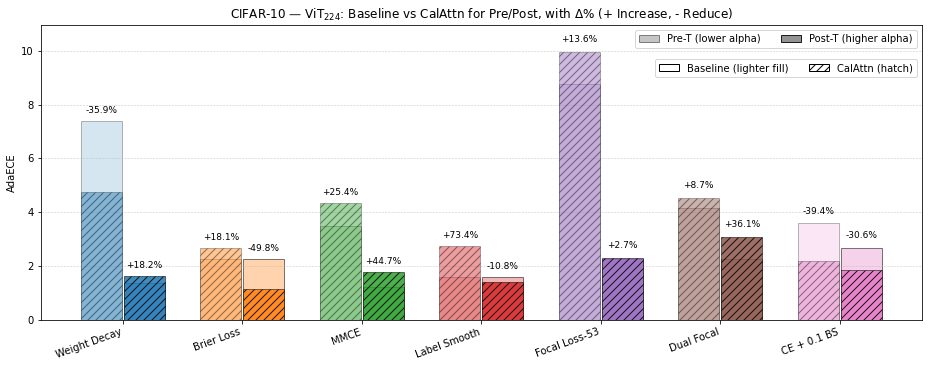

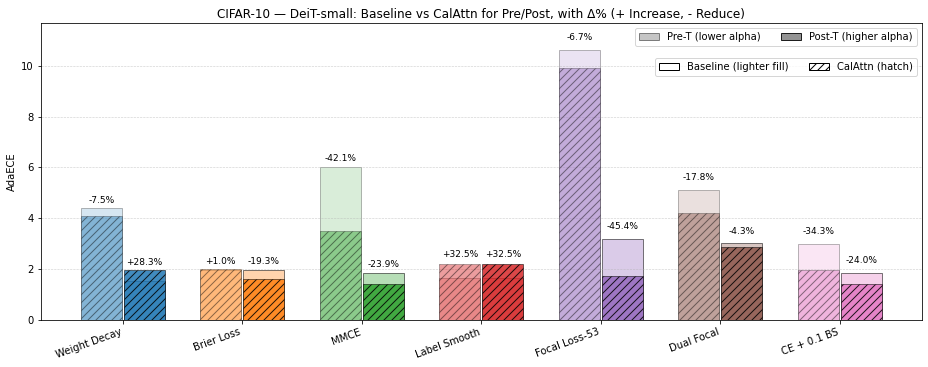

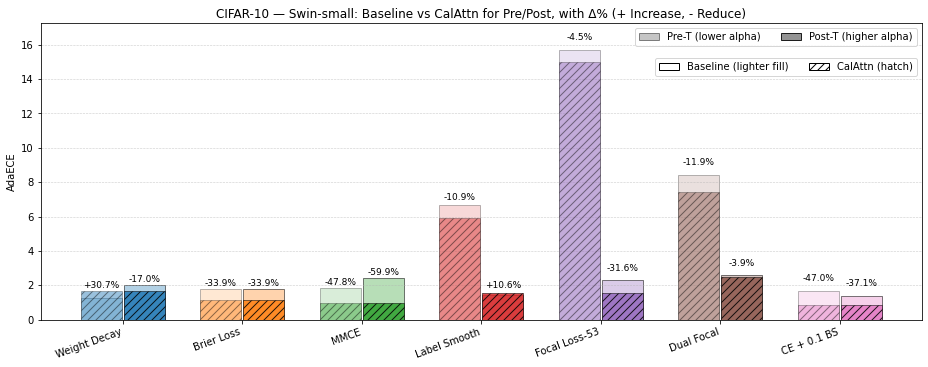

{'ViT$_{224}$': '../../outputs/plotSave/adaECE_cifar10_compare_baseline_vs_calattn_prepost_delta_vit224.png',
 'DeiT-small': '../../outputs/plotSave/adaECE_cifar10_compare_baseline_vs_calattn_prepost_delta_deitsmall.png',
 'Swin-small': '../../outputs/plotSave/adaECE_cifar10_compare_baseline_vs_calattn_prepost_delta_swinsmall.png'}

In [34]:
# adaECE — CIFAR-10
c10_rows = [
    ("ViT$_{224}$", "Baseline",
     [7.39, "1.37(1.30)",
      2.27, "2.27(1.00)",
      3.47, "1.23(1.10)",
      1.58, "1.58(1.00)",
      8.77, "2.24(0.70)",
      4.16, "2.27(0.90)",
      3.58, "2.68(1.40)"]),

    ("ViT$_{224}$", "CalAttn (Ours)",
     [4.74, "1.62(1.20)",
      2.68, "1.14(1.10)",
      4.35, "1.78(1.20)",
      2.74, "1.41(0.90)",
      9.96, "2.30(0.70)",
      4.52, "3.09(0.90)",
      2.17, "1.86(1.10)"]),

    ("DeiT-small", "Baseline",
     [4.41, "1.52(1.20)",
      1.97, "1.97(1.00)",
      6.01, "1.84(1.20)",
      1.66, "1.66(1.00)",
      10.62, "3.17(0.70)",
      5.11, "3.00(0.80)",
      2.97, "1.83(1.30)"]),

    ("DeiT-small", "CalAttn (Ours)",
     [4.08, "1.95(1.10)",
      1.99, "1.59(1.10)",
      3.48, "1.40(1.10)",
      2.20, "2.20(1.00)",
      9.91, "1.73(0.70)",
      4.20, "2.87(0.90)",
      1.95, "1.39(1.10)"]),

    ("Swin-small", "Baseline",
     [1.27, "2.00(0.90)",
      1.77, "1.77(1.00)",
      1.86, "2.42(0.90)",
      6.67, "1.41(0.80)",
      15.69, "2.28(0.60)",
      8.40, "2.57(0.70)",
      1.66, "1.40(1.20)"]),

    ("Swin-small", "CalAttn (Ours)",
     [1.66, "1.66(1.00)",
      1.17, "1.17(1.00)",
      0.97, "0.97(1.00)",
      5.94, "1.56(0.80)",
      14.98, "1.56(0.60)",
      7.40, "2.47(0.80)",
      0.88, "0.88(1.00)"]),
]


def parse_post_value(x):
    if isinstance(x, (int, float)):
        return float(x)
    m = re.match(r"\s*([0-9]*\.?[0-9]+)\s*(?:\(([^)]*)\))?\s*$", str(x))
    if not m:
        raise ValueError(f"Cannot parse: {x}")
    return float(m.group(1))

data = []
for arch, variant, vals in c10_rows:
    for i, method in enumerate(methods):
        pre = float(vals[2*i])
        post = parse_post_value(vals[2*i + 1])
        data.append({"Architecture": arch, "Variant": variant, "Method": method, "Pre-T": pre, "Post-T": post})
df100 = pd.DataFrame(data)

# Colors: one hue per method
tab10 = plt.get_cmap("tab10").colors
method_colors = {m: tab10[i % len(tab10)] for i, m in enumerate(methods)}

def lighten(color, amount=0.60):
    c = np.array(mcolors.to_rgb(color))
    return tuple(c + (1 - c) * amount)

def plot_compare_calattn_vs_baseline_prepost(arch, outfile):
    base = df100[(df100["Architecture"] == arch) & (df100["Variant"] == "Baseline")].copy()
    cal  = df100[(df100["Architecture"] == arch) & (df100["Variant"] == "CalAttn (Ours)")].copy()

    base["Method"] = pd.Categorical(base["Method"], categories=methods, ordered=True)
    cal["Method"]  = pd.Categorical(cal["Method"],  categories=methods, ordered=True)
    base = base.sort_values("Method")
    cal  = cal.sort_values("Method")

    x = np.arange(len(methods))
    dx = 0.18
    w = 0.34  # same width for all bars
    stage_alpha = {"Pre-T": 0.45, "Post-T": 0.85}

    plt.figure(figsize=(13.0, 5.2))
    ax = plt.gca()

    ymax = 0.0
    for i, m in enumerate(methods):
        col = method_colors[m]
        b_pre  = float(base[base["Method"] == m]["Pre-T"].iloc[0])
        b_post = float(base[base["Method"] == m]["Post-T"].iloc[0])
        c_pre  = float(cal[cal["Method"] == m]["Pre-T"].iloc[0])
        c_post = float(cal[cal["Method"] == m]["Post-T"].iloc[0])
        ymax = max(ymax, b_pre, b_post, c_pre, c_post)

        pre_pos = x[i] - dx
        post_pos = x[i] + dx

        # PRE: overlay baseline then calattn (same width)
        ax.bar(pre_pos, b_pre,  width=w, color=lighten(col), alpha=stage_alpha["Pre-T"],
               edgecolor="black", linewidth=0.6, zorder=1)
        ax.bar(pre_pos, c_pre,  width=w, color=col, alpha=stage_alpha["Pre-T"],
               edgecolor="black", linewidth=0.6, hatch="///", zorder=2)

        # POST: overlay baseline then calattn (same width)
        ax.bar(post_pos, b_post, width=w, color=lighten(col), alpha=stage_alpha["Post-T"],
               edgecolor="black", linewidth=0.6, zorder=1)
        ax.bar(post_pos, c_post, width=w, color=col, alpha=stage_alpha["Post-T"],
               edgecolor="black", linewidth=0.6, hatch="///", zorder=2)

        # Δ% labels (CalAttn vs Baseline), one for pre and one for post
        dpre  = (c_pre  - b_pre)  / b_pre  * 100.0 if b_pre  != 0 else np.nan
        dpost = (c_post - b_post) / b_post * 100.0 if b_post != 0 else np.nan
        ax.text(pre_pos,  max(b_pre,  c_pre)  + 0.03*ymax, f"{dpre:+.1f}%",
                ha="center", va="bottom", fontsize=9)
        ax.text(post_pos, max(b_post, c_post) + 0.03*ymax, f"{dpost:+.1f}%",
                ha="center", va="bottom", fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=20, ha="right")
    ax.set_ylabel("AdaECE")
    ax.set_title(f"CIFAR-10 — {arch}: Baseline vs CalAttn for Pre/Post, with Δ% (+ Increase, - Reduce)")
    ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)
    ax.set_ylim(0, ymax * 1.1)

    method_legend = [Patch(facecolor=method_colors[m], edgecolor="black", label=m) for m in methods]

    # handles = method_legend
    # labels = [h.get_label() for h in handles]
    # leg1 = place_legend_no_overlap(ax, handles, labels, ncol=2)
    # ax.add_artist(leg1)



    variant_legend = [
        Patch(facecolor="white", edgecolor="black", hatch="", label="Baseline (lighter fill)"),
        Patch(facecolor="white", edgecolor="black", hatch="///", label="CalAttn (hatch)"),
    ]
    leg2 = ax.legend(handles=variant_legend, ncol=2,
                     loc="upper right", bbox_to_anchor=(1.0, 0.9), frameon=True)
    ax.add_artist(leg2)

    stage_legend = [
        Patch(facecolor="gray", edgecolor="black", alpha=stage_alpha["Pre-T"], label="Pre-T (lower alpha)"),
        Patch(facecolor="gray", edgecolor="black", alpha=stage_alpha["Post-T"], label="Post-T (higher alpha)"),
    ]
    ax.legend(handles=stage_legend, ncol=2,
              loc="upper right", bbox_to_anchor=(1.0, 1.0), frameon=True)

    plt.tight_layout()
    plt.savefig(outfile, dpi=220, bbox_inches="tight")
    plt.show()

out_compare = {}
for arch in ["ViT$_{224}$", "DeiT-small", "Swin-small"]:
    safe_arch = arch.replace("$","").replace("{","").replace("}","").replace("_","").replace("\\","").replace(" ","").replace("-","").lower()
    path = f"../../outputs/plotSave/adaECE_cifar10_compare_baseline_vs_calattn_prepost_delta_{safe_arch}.png"
    out_compare[arch] = path
    plot_compare_calattn_vs_baseline_prepost(arch, path)

out_compare

In [32]:
# adaECE — CIFAR-100
c100_rows = [
    ("ViT$_{224}$", "Baseline",
     [13.11, "3.34(1.30)",
      2.58, "2.56(1.10)",
      11.51, "2.33(1.30)",
      3.77, "2.32(1.10)",
      5.07, "3.41(1.10)",
      3.56, "3.56(1.00)",
      6.55, "3.54(1.50)"]),

    ("ViT$_{224}$", "CalAttn (Ours)",
     [8.25, "1.83(1.20)",
      1.93, "2.56(1.10)",
      9.04, "2.11(1.20)",
      2.12, "2.12(1.00)",
      2.60, "2.60(1.00)",
      3.73, "2.07(1.10)",
      4.01, "1.47(1.10)"]),

    ("DeiT-small", "Baseline",
     [7.46, "3.57(1.10)",
      2.26, "2.26(1.00)",
      7.88, "2.35(1.20)",
      1.67, "1.67(1.00)",
      3.18, "3.18(1.00)",
      2.01, "2.01(1.00)",
      5.93, "2.85(1.40)"]),

    ("DeiT-small", "CalAttn (Ours)",
     [6.87, "1.04(1.20)",
      1.92, "2.41(1.10)",
      6.51, "1.34(1.20)",
      1.67, "1.67(1.00)",
      3.08, "3.08(1.00)",
      3.05, "2.47(1.10)",
      4.36, "1.73(1.10)"]),

    ("Swin-small", "Baseline",
     [3.58, "2.52(0.90)",
      2.60, "2.60(1.00)",
      3.54, "2.75(0.90)",
      9.29, "2.56(0.80)",
      10.71, "2.71(0.80)",
      8.24, "3.16(0.80)",
      4.07, "2.93(1.20)"]),

    ("Swin-small", "CalAttn (Ours)",
     [2.20, "2.20(1.00)",
      2.95, "2.24(1.10)",
      1.97, "1.97(1.00)",
      6.55, "2.65(0.90)",
      6.10, "3.16(0.90)",
      3.85, "3.22(0.90)",
      1.75, "1.75(1.00)"]),
]


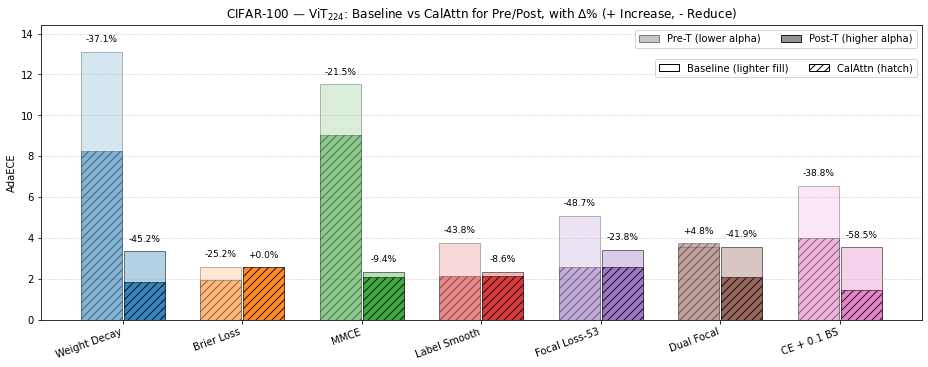

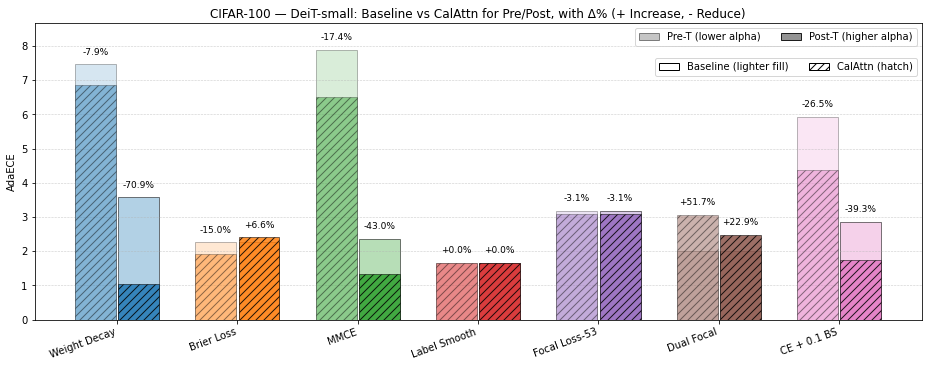

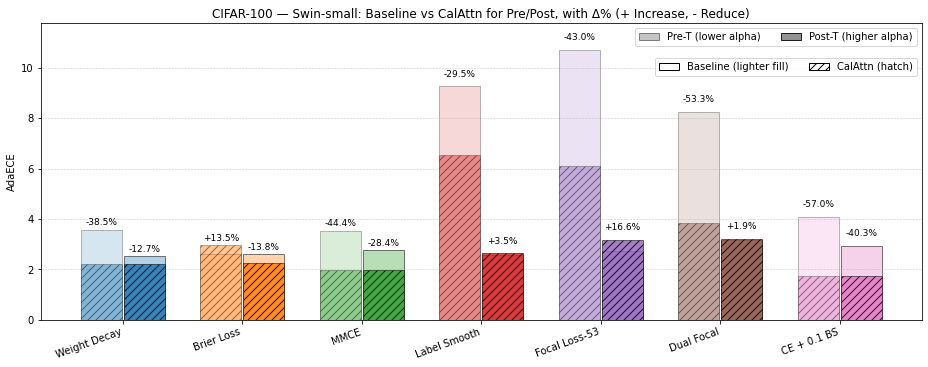

{'ViT$_{224}$': '../../outputs/plotSave/adaECE_cifar100_compare_baseline_vs_calattn_prepost_delta_vit224.png',
 'DeiT-small': '../../outputs/plotSave/adaECE_cifar100_compare_baseline_vs_calattn_prepost_delta_deitsmall.png',
 'Swin-small': '../../outputs/plotSave/adaECE_cifar100_compare_baseline_vs_calattn_prepost_delta_swinsmall.png'}

In [33]:

def parse_post_value(x):
    if isinstance(x, (int, float)):
        return float(x)
    m = re.match(r"\s*([0-9]*\.?[0-9]+)\s*(?:\(([^)]*)\))?\s*$", str(x))
    if not m:
        raise ValueError(f"Cannot parse: {x}")
    return float(m.group(1))

data = []
for arch, variant, vals in c100_rows:
    for i, method in enumerate(methods):
        pre = float(vals[2*i])
        post = parse_post_value(vals[2*i + 1])
        data.append({"Architecture": arch, "Variant": variant, "Method": method, "Pre-T": pre, "Post-T": post})
df100 = pd.DataFrame(data)

# Colors: one hue per method
tab10 = plt.get_cmap("tab10").colors
method_colors = {m: tab10[i % len(tab10)] for i, m in enumerate(methods)}

def lighten(color, amount=0.60):
    c = np.array(mcolors.to_rgb(color))
    return tuple(c + (1 - c) * amount)

def plot_compare_calattn_vs_baseline_prepost(arch, outfile):
    base = df100[(df100["Architecture"] == arch) & (df100["Variant"] == "Baseline")].copy()
    cal  = df100[(df100["Architecture"] == arch) & (df100["Variant"] == "CalAttn (Ours)")].copy()

    base["Method"] = pd.Categorical(base["Method"], categories=methods, ordered=True)
    cal["Method"]  = pd.Categorical(cal["Method"],  categories=methods, ordered=True)
    base = base.sort_values("Method")
    cal  = cal.sort_values("Method")

    x = np.arange(len(methods))
    dx = 0.18
    w = 0.34  # same width for all bars
    stage_alpha = {"Pre-T": 0.45, "Post-T": 0.85}

    plt.figure(figsize=(13.0, 5.2))
    ax = plt.gca()

    ymax = 0.0
    for i, m in enumerate(methods):
        col = method_colors[m]
        b_pre  = float(base[base["Method"] == m]["Pre-T"].iloc[0])
        b_post = float(base[base["Method"] == m]["Post-T"].iloc[0])
        c_pre  = float(cal[cal["Method"] == m]["Pre-T"].iloc[0])
        c_post = float(cal[cal["Method"] == m]["Post-T"].iloc[0])
        ymax = max(ymax, b_pre, b_post, c_pre, c_post)

        pre_pos = x[i] - dx
        post_pos = x[i] + dx

        # PRE: overlay baseline then calattn (same width)
        ax.bar(pre_pos, b_pre,  width=w, color=lighten(col), alpha=stage_alpha["Pre-T"],
               edgecolor="black", linewidth=0.6, zorder=1)
        ax.bar(pre_pos, c_pre,  width=w, color=col, alpha=stage_alpha["Pre-T"],
               edgecolor="black", linewidth=0.6, hatch="///", zorder=2)

        # POST: overlay baseline then calattn (same width)
        ax.bar(post_pos, b_post, width=w, color=lighten(col), alpha=stage_alpha["Post-T"],
               edgecolor="black", linewidth=0.6, zorder=1)
        ax.bar(post_pos, c_post, width=w, color=col, alpha=stage_alpha["Post-T"],
               edgecolor="black", linewidth=0.6, hatch="///", zorder=2)

        # Δ% labels (CalAttn vs Baseline), one for pre and one for post
        dpre  = (c_pre  - b_pre)  / b_pre  * 100.0 if b_pre  != 0 else np.nan
        dpost = (c_post - b_post) / b_post * 100.0 if b_post != 0 else np.nan
        ax.text(pre_pos,  max(b_pre,  c_pre)  + 0.03*ymax, f"{dpre:+.1f}%",
                ha="center", va="bottom", fontsize=9)
        ax.text(post_pos, max(b_post, c_post) + 0.03*ymax, f"{dpost:+.1f}%",
                ha="center", va="bottom", fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=20, ha="right")
    ax.set_ylabel("AdaECE")
    ax.set_title(f"CIFAR-100 — {arch}: Baseline vs CalAttn for Pre/Post, with Δ% (+ Increase, - Reduce)")
    ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)
    ax.set_ylim(0, ymax * 1.1)

    method_legend = [Patch(facecolor=method_colors[m], edgecolor="black", label=m) for m in methods]

    # handles = method_legend
    # labels = [h.get_label() for h in handles]
    # leg1 = place_legend_no_overlap(ax, handles, labels, ncol=2)
    # ax.add_artist(leg1)



    variant_legend = [
        Patch(facecolor="white", edgecolor="black", hatch="", label="Baseline (lighter fill)"),
        Patch(facecolor="white", edgecolor="black", hatch="///", label="CalAttn (hatch)"),
    ]
    leg2 = ax.legend(handles=variant_legend, ncol=2,
                     loc="upper right", bbox_to_anchor=(1.0, 0.9), frameon=True)
    ax.add_artist(leg2)

    stage_legend = [
        Patch(facecolor="gray", edgecolor="black", alpha=stage_alpha["Pre-T"], label="Pre-T (lower alpha)"),
        Patch(facecolor="gray", edgecolor="black", alpha=stage_alpha["Post-T"], label="Post-T (higher alpha)"),
    ]
    ax.legend(handles=stage_legend, ncol=2,
              loc="upper right", bbox_to_anchor=(1.0, 1.0), frameon=True)

    plt.tight_layout()
    plt.savefig(outfile, dpi=220, bbox_inches="tight")
    plt.show()

out_compare = {}
for arch in ["ViT$_{224}$", "DeiT-small", "Swin-small"]:
    safe_arch = arch.replace("$","").replace("{","").replace("}","").replace("_","").replace("\\","").replace(" ","").replace("-","").lower()
    path = f"../../outputs/plotSave/adaECE_cifar100_compare_baseline_vs_calattn_prepost_delta_{safe_arch}.png"
    out_compare[arch] = path
    plot_compare_calattn_vs_baseline_prepost(arch, path)

out_compare


In [29]:
def plot_3arches_compact_onelegend(df100, outfile):
    arches = ["ViT$_{224}$", "DeiT-small", "Swin-small"]
    arch_titles = {"ViT$_{224}$": "ViT-224", "DeiT-small": "DeiT-S", "Swin-small": "Swin-S"}

    # ---- compact knobs ----
    step = 0.78              # < 1 => smaller gap between losses (try 0.70~0.85)
    dx   = 0.12 * step        # pre/post separation
    w    = 0.22 * step        # bar width
    stage_alpha = {"Pre-T": 0.45, "Post-T": 0.85}

    # Short x tick labels for 1-column
    short = {
        "Weight Decay": "WD",
        "Brier Loss": "BS",
        "MMCE": "MMCE",
        "Label Smooth": "LS",
        "Focal Loss-53": "Focal",
        "Dual Focal": "Dual",
        r"CE + 0.1 BS": "CE+BS",
    }
    xticks = [short[m] for m in methods]

    # 1-column friendly size (tune height if needed)
    fig, axes = plt.subplots(
        nrows=3, ncols=1, sharex=True,
        figsize=(6.45, 4.20),   # ~ single-column width; reduce height if too tall
        gridspec_kw={"hspace": 0.15}
    )

    x = np.arange(len(methods)) * step

    for ax, arch in zip(axes, arches):
        base = df100[(df100["Architecture"] == arch) & (df100["Variant"] == "Baseline")].copy()
        cal  = df100[(df100["Architecture"] == arch) & (df100["Variant"] == "CalAttn (Ours)")].copy()

        base["Method"] = pd.Categorical(base["Method"], categories=methods, ordered=True)
        cal["Method"]  = pd.Categorical(cal["Method"],  categories=methods, ordered=True)
        base = base.sort_values("Method")
        cal  = cal.sort_values("Method")

        ymax = max(base["Pre-T"].max(), base["Post-T"].max(), cal["Pre-T"].max(), cal["Post-T"].max())

        for i, m in enumerate(methods):
            col = method_colors[m]

            b_pre  = float(base[base["Method"] == m]["Pre-T"].iloc[0])
            b_post = float(base[base["Method"] == m]["Post-T"].iloc[0])
            c_pre  = float(cal[cal["Method"] == m]["Pre-T"].iloc[0])
            c_post = float(cal[cal["Method"] == m]["Post-T"].iloc[0])

            pre_pos  = x[i] - dx
            post_pos = x[i] + dx

            # PRE: baseline then calattn overlay (same width)
            ax.bar(pre_pos, b_pre,  width=w, color=lighten(col), alpha=stage_alpha["Pre-T"],
                   edgecolor="black", linewidth=0.5, zorder=1)
            ax.bar(pre_pos, c_pre,  width=w, color=col, alpha=stage_alpha["Pre-T"],
                   edgecolor="black", linewidth=0.5, hatch="///", zorder=2)

            # POST: baseline then calattn overlay (same width)
            ax.bar(post_pos, b_post, width=w, color=lighten(col), alpha=stage_alpha["Post-T"],
                   edgecolor="black", linewidth=0.5, zorder=1)
            ax.bar(post_pos, c_post, width=w, color=col, alpha=stage_alpha["Post-T"],
                   edgecolor="black", linewidth=0.5, hatch="///", zorder=2)

            # Δ% labels (CalAttn vs Baseline) for both Pre/Post (small font for compactness)
            dpre  = (c_pre  - b_pre)  / b_pre  * 100.0 if b_pre  != 0 else np.nan
            dpost = (c_post - b_post) / b_post * 100.0 if b_post != 0 else np.nan
            ax.text(pre_pos,  max(b_pre,  c_pre)  + 0.02*ymax, f"{dpre:+.1f}%",
                    ha="center", va="bottom", fontsize=6)
            ax.text(post_pos, max(b_post, c_post) + 0.02*ymax, f"{dpost:+.1f}%",
                    ha="center", va="bottom", fontsize=6)

        ax.set_ylim(0, ymax * 1.10)
        ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.45)
        ax.set_title(arch_titles[arch], fontsize=9, pad=2)
        ax.tick_params(axis="y", labelsize=7)

    # shared x ticks only at bottom
    axes[-1].set_xticks(x)
    axes[-1].set_xticklabels(xticks, rotation=0, fontsize=7)
    axes[-1].set_xlabel("Loss / training objective", fontsize=8)

    # y label (shared feel)
    fig.text(0.01, 0.50, "ECE", va="center", rotation="vertical", fontsize=8)

    # ---- One shared method-color legend only ----
    method_legend = [Patch(facecolor=method_colors[m], edgecolor="black", label=short[m]) for m in methods]
    fig.legend(
        handles=method_legend,
        loc="lower center",
        ncol=7,                 # single row
        frameon=False,
        fontsize=7,
        bbox_to_anchor=(0.5, -0.01),
        handlelength=1.0,
        columnspacing=0.8
    )

    # Leave a bit of room for the legend at bottom
    plt.tight_layout(rect=[0.53, 0.5, 2.0, 2.0])
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()


<ipython-input-29-adbc48c91250>:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.53, 0.5, 2.0, 2.0])


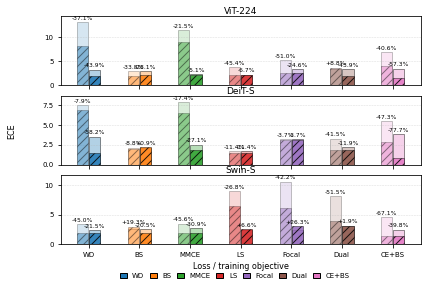

In [30]:
plot_3arches_compact_onelegend(
    df100,
    "../../outputs/plotSave/cifar100_3arches_compact_onelegend.png"
)


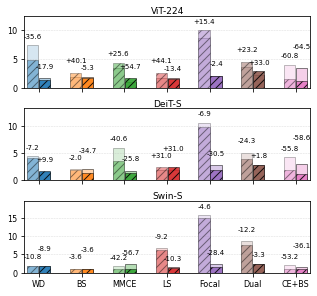

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def _texts_overlap(t1, t2, renderer):
    b1 = t1.get_window_extent(renderer=renderer).expanded(1.02, 1.10)
    b2 = t2.get_window_extent(renderer=renderer).expanded(1.02, 1.10)
    return (b1.x0 < b2.x1 and b1.x1 > b2.x0 and b1.y0 < b2.y1 and b1.y1 > b2.y0)

def _place_text_no_overlap(ax, x, y, s, *, placed_texts, base_offset=6, step_offset=5, max_tries=10, fontsize=7):
    """
    Place a text with point-offset above (x,y). If it overlaps with previous texts,
    keep shifting upward by step_offset points until it doesn't overlap.
    """
    fig = ax.figure
    # initial offset in points
    dy = base_offset
    t = ax.annotate(
        s, xy=(x, y), xytext=(0, dy),
        textcoords="offset points",
        ha="center", va="bottom",
        fontsize=fontsize
    )
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    tries = 0
    while tries < max_tries:
        conflict = any(_texts_overlap(t, prev, renderer) for prev in placed_texts)
        if not conflict:
            break
        dy += step_offset
        t.set_position((0, dy))
        fig.canvas.draw()
        tries += 1

    placed_texts.append(t)
    return t

def _texts_overlap(t1, t2, renderer, expand=(1.02, 1.10)):
    b1 = t1.get_window_extent(renderer=renderer).expanded(*expand)
    b2 = t2.get_window_extent(renderer=renderer).expanded(*expand)
    return (b1.x0 < b2.x1 and b1.x1 > b2.x0 and b1.y0 < b2.y1 and b1.y1 > b2.y0)

def place_text_no_overlap_xy(
    ax, x, y, s, *,
    placed_texts,
    x_offsets_pts=(0, 4, -4, 8, -8, 12, -12),
    y_start_pts=6,
    y_step_pts=5,
    max_y_tries=14,
    fontsize=7
):
    """
    Place a delta label using (x,y) anchor but with point-offsets searched in 2D:
    try multiple x offsets and progressively larger y offsets until no overlap with prior labels.
    """
    fig = ax.figure

    # Create once, then update offsets
    t = ax.annotate(
        s, xy=(x, y),
        xytext=(0, y_start_pts),
        textcoords="offset points",
        ha="center", va="bottom",
        fontsize=fontsize
    )

    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    for k in range(max_y_tries):
        dy = y_start_pts + k * y_step_pts

        # Try a set of x offsets at this dy
        for dx in x_offsets_pts:
            t.set_position((dx, dy))
            fig.canvas.draw()

            conflict = any(_texts_overlap(t, prev, renderer) for prev in placed_texts)
            if not conflict:
                placed_texts.append(t)
                return t

    # If still conflicts, keep the last position (highest dy, last dx)
    placed_texts.append(t)
    return t


def plot_3arches_compact_onelegend_better(df100, outfile):
    # ---------- style (bigger fonts) ----------
    plt.rcParams.update({
        "font.size": 8,
        "axes.titlesize": 9,
        "axes.labelsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,
    })

    arches = ["ViT$_{224}$", "DeiT-small", "Swin-small"]
    arch_titles = {"ViT$_{224}$": "ViT-224", "DeiT-small": "DeiT-S", "Swin-small": "Swin-S"}

    # ---------- compactness knobs ----------
    step = 0.86                 # smaller gap between methods; try 0.80~0.92
    dx   = 0.14 * step          # pre/post separation
    w    = 0.26 * step          # bar width
    stage_alpha = {"Pre-T": 0.45, "Post-T": 0.88}

    # Short x tick labels
    short = {
        "Weight Decay": "WD",
        "Brier Loss": "BS",
        "MMCE": "MMCE",
        "Label Smooth": "LS",
        "Focal Loss-53": "Focal",
        "Dual Focal": "Dual",
        r"CE + 0.1 BS": "CE+BS",
    }
    xticks = [short[m] for m in methods]
    x = np.arange(len(methods)) * step

    # ---------- figure ----------
    # Slightly larger than strict 1-col; still compact for paper.
    fig, axes = plt.subplots(
        nrows=3, ncols=1, sharex=True,
        figsize=(4.3, 4.0),
        constrained_layout=True
    )

    for ax, arch in zip(axes, arches):
        base = df100[(df100["Architecture"] == arch) & (df100["Variant"] == "Baseline")].copy()
        cal  = df100[(df100["Architecture"] == arch) & (df100["Variant"] == "CalAttn (Ours)")].copy()

        base["Method"] = pd.Categorical(base["Method"], categories=methods, ordered=True)
        cal["Method"]  = pd.Categorical(cal["Method"],  categories=methods, ordered=True)
        base = base.sort_values("Method")
        cal  = cal.sort_values("Method")

        ymax = max(base["Pre-T"].max(), base["Post-T"].max(), cal["Pre-T"].max(), cal["Post-T"].max())
        placed_texts = []  # track texts for overlap-avoidance (per axis)

        for i, m in enumerate(methods):
            col = method_colors[m]

            b_pre  = float(base[base["Method"] == m]["Pre-T"].iloc[0])
            b_post = float(base[base["Method"] == m]["Post-T"].iloc[0])
            c_pre  = float(cal[cal["Method"] == m]["Pre-T"].iloc[0])
            c_post = float(cal[cal["Method"] == m]["Post-T"].iloc[0])

            pre_pos  = x[i] - dx
            post_pos = x[i] + dx

            # Bars: Baseline underlay + CalAttn overlay
            ax.bar(pre_pos,  b_pre,  width=w, color=lighten(col), alpha=stage_alpha["Pre-T"],
                   edgecolor="black", linewidth=0.55, zorder=1)
            ax.bar(pre_pos,  c_pre,  width=w, color=col, alpha=stage_alpha["Pre-T"],
                   edgecolor="black", linewidth=0.55, hatch="///", zorder=2)

            ax.bar(post_pos, b_post, width=w, color=lighten(col), alpha=stage_alpha["Post-T"],
                   edgecolor="black", linewidth=0.55, zorder=1)
            ax.bar(post_pos, c_post, width=w, color=col, alpha=stage_alpha["Post-T"],
                   edgecolor="black", linewidth=0.55, hatch="///", zorder=2)

            # Δ% labels (CalAttn vs Baseline)
            dpre  = (c_pre  - b_pre)  / b_pre  * 100.0 if b_pre  != 0 else np.nan
            dpost = (c_post - b_post) / b_post * 100.0 if b_post != 0 else np.nan

            # Use the higher bar as anchor, then offset in points; auto-resolve overlaps
            y_anchor_pre  = max(b_pre,  c_pre)
            y_anchor_post = max(b_post, c_post)

            # Alternate base offset slightly to reduce collisions
            base_off_pre  = 6 + (i % 2) * 3
            base_off_post = 6 + ((i + 1) % 2) * 3

            _place_text_no_overlap(ax, pre_pos,  y_anchor_pre,  f"{dpre:+.1f}",
                                   placed_texts=placed_texts, base_offset=base_off_pre, fontsize=7)
            _place_text_no_overlap(ax, post_pos, y_anchor_post, f"{dpost:+.1f}",
                                   placed_texts=placed_texts, base_offset=base_off_post, fontsize=7)

        ax.set_ylim(0, ymax * 1.25)
        ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.45)
        ax.set_title(arch_titles[arch], pad=2)
        ax.margins(x=0.01)

    axes[-1].set_xticks(x)
    axes[-1].set_xticklabels(xticks, rotation=0)
    # fig.text(0.0, 0.50, "ECE", va="center", rotation="vertical", size=100, )

    # # One shared method-color legend only
    # method_legend = [Patch(facecolor=method_colors[m], edgecolor="black", label=short[m]) for m in methods]
    # fig.legend(
    #     handles=method_legend,
    #     loc="lower center",
    #     ncol=7,
    #     frameon=False,
    #     bbox_to_anchor=(0.5, -0.01),
    #     handlelength=1.0,
    #     columnspacing=0.9
    # )

    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()
plot_3arches_compact_onelegend_better(
    df100,
    "../../outputs/plotSave/cifar100_3arches_compact_onelegend_better.png"
)


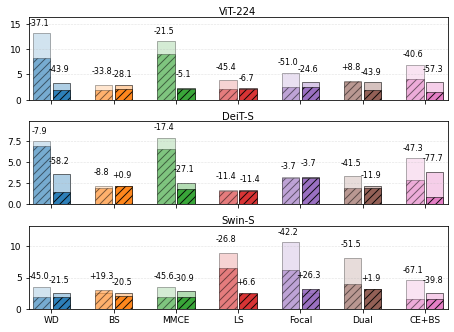

In [50]:
# =========================
# Compact paper plot (3 arches in one figure)
# - Color = loss/method (ONE shared legend)
# - Within each method: Pre (left) / Post (right)
# - Overlay: Baseline (lighter) + CalAttn (hatched)
# - Δ% labels for BOTH pre & post, with 2D (x/y) auto-shift to avoid overlaps
# =========================

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import colors as mcolors

# -------------------------
# 1) METHODS (order must match your tables)
# -------------------------
methods = [
    "Weight Decay",
    "Brier Loss",
    "MMCE",
    "Label Smooth",
    "Focal Loss-53",
    "Dual Focal",
    r"CE + 0.1 BS",
]

# Optional short labels for tight x-axis
SHORT = {
    "Weight Decay": "WD",
    "Brier Loss": "BS",
    "MMCE": "MMCE",
    "Label Smooth": "LS",
    "Focal Loss-53": "Focal",
    "Dual Focal": "Dual",
    r"CE + 0.1 BS": "CE+BS",
}

# -------------------------
# 2) PUT YOUR ROWS HERE
#    Format: (arch, variant, [pre1, post1, pre2, post2, ...])
#    post can be "x.xx(T)" string; we parse x.xx
# -------------------------
c100_rows = [
    ("ViT$_{224}$", "Baseline",
     [13.11, "3.30(1.30)", 2.99, "2.99(1.00)", 11.52, "2.34(1.30)", 3.83, "2.24(1.10)", 5.33, "3.46(1.10)", 3.42, "3.42(1.00)", 6.89, "3.49(1.50)"]),
    ("ViT$_{224}$", "CalAttn (Ours)",
     [8.25, "1.85(1.20)", 1.98, "2.15(1.10)", 9.04, "2.22(1.20)", 2.09, "2.09(1.00)", 2.61, "2.61(1.00)", 3.72, "1.92(1.10)", 4.09, "1.49(1.10)"]),
    ("DeiT-small", "Baseline",
     [7.46, "3.54(1.10)", 2.17, "2.17(1.00)", 7.88, "2.55(1.20)", 1.75, "1.75(1.00)", 3.27, "3.27(1.00)", 3.30, "2.19(1.10)", 5.46, "3.86(1.40)"]),
    ("DeiT-small", "CalAttn (Ours)",
     [6.87, "1.48(1.20)", 1.98, "2.19(1.10)", 6.51, "1.86(1.20)", 1.55, "1.55(1.00)", 3.15, "3.15(1.00)", 1.93, "1.93(1.00)", 2.88, "0.86(1.10)"]),
    ("Swin-small", "Baseline",
     [3.51, "2.46(0.90)", 2.54, "2.54(1.00)", 3.53, "2.78(0.90)", 9.00, "2.41(0.80)", 10.64, "2.51(0.80)", 8.18, "3.15(0.80)", 4.59, "2.51(1.20)"]),
    ("Swin-small", "CalAttn (Ours)",
     [1.93, "1.93(1.00)", 3.03, "2.02(1.10)", 1.92, "1.92(1.00)", 6.59, "2.57(0.90)", 6.15, "3.17(0.90)", 3.97, "3.21(0.90)", 1.51, "1.51(1.00)"]),
]


# -------------------------
# 3) Helpers: parse + colors
# -------------------------
def parse_post_value(x):
    """Accept float/int or string like '1.68(1.30)' and return the leading float."""
    if isinstance(x, (int, float)):
        return float(x)
    m = re.match(r"\s*([0-9]*\.?[0-9]+)\s*(?:\(([^)]*)\))?\s*$", str(x))
    if not m:
        raise ValueError(f"Cannot parse post value: {x}")
    return float(m.group(1))

def build_df(rows):
    data = []
    for arch, variant, vals in rows:
        for i, method in enumerate(methods):
            pre = float(vals[2*i])
            post = parse_post_value(vals[2*i + 1])
            data.append({
                "Architecture": arch,
                "Variant": variant,
                "Method": method,
                "Pre-T": pre,
                "Post-T": post
            })
    return pd.DataFrame(data)

# One hue per method
tab10 = plt.get_cmap("tab10").colors
method_colors = {m: tab10[i % len(tab10)] for i, m in enumerate(methods)}

def lighten(color, amount=0.60):
    c = np.array(mcolors.to_rgb(color))
    return tuple(c + (1 - c) * amount)


# -------------------------
# 4) Delta label placement: 2D search (x/y offsets in points)
# -------------------------
def _texts_overlap(t1, t2, renderer, expand=(1.02, 1.10)):
    b1 = t1.get_window_extent(renderer=renderer).expanded(*expand)
    b2 = t2.get_window_extent(renderer=renderer).expanded(*expand)
    return (b1.x0 < b2.x1 and b1.x1 > b2.x0 and b1.y0 < b2.y1 and b1.y1 > b2.y0)

def place_text_no_overlap_xy(
    ax, x, y, s, *,
    placed_texts,
    x_offsets_pts=(0, 4, -4, 8, -8, 12, -12),
    y_start_pts=6,
    y_step_pts=5,
    max_y_tries=16,
    fontsize=8
):
    """
    Place a label above (x,y) using offset-points search in 2D.
    Tries multiple x offsets, then increases y offset until no overlap with existing labels.
    """
    fig = ax.figure

    t = ax.annotate(
        s, xy=(x, y),
        xytext=(0, y_start_pts),
        textcoords="offset points",
        ha="center", va="bottom",
        fontsize=fontsize,
        zorder=10
    )

    # Need a draw to compute bboxes
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    for k in range(max_y_tries):
        dy = y_start_pts + k * y_step_pts
        for dx in x_offsets_pts:
            t.set_position((dx, dy))
            fig.canvas.draw()
            if not any(_texts_overlap(t, prev, renderer) for prev in placed_texts):
                placed_texts.append(t)
                return t

    placed_texts.append(t)
    return t


# -------------------------
# 5) Main plot function: 3 arches, one shared method legend, compact spacing
# -------------------------
def plot_3arches_compact_onelegend(
    df,
    outfile,
    *,
    metric_name="ECE",
    title=None,
    arches=("ViT$_{224}$", "DeiT-small", "Swin-small"),
    arch_titles=None,
    # ---- geometry knobs ----
    step=0.90,          # smaller => tighter gaps between methods; try 0.82~0.95
    dx_frac=0.16,       # pre/post separation as fraction of step
    w_frac=0.28,        # bar width as fraction of step
    # ---- fonts ----
    fig_size=(5.2, 4.5),
    delta_font=8,
    tick_font=9,
    title_font=10,
):
    if arch_titles is None:
        arch_titles = {arches[0]: "ViT-224", arches[1]: "DeiT-S", arches[2]: "Swin-S"}

    plt.rcParams.update({
        "font.size": tick_font,
        "axes.titlesize": title_font,
        "axes.labelsize": tick_font,
        "xtick.labelsize": tick_font,
        "ytick.labelsize": tick_font,
        "legend.fontsize": tick_font,
    })

    dx = dx_frac * step
    w  = w_frac  * step
    stage_alpha = {"Pre-T": 0.50, "Post-T": 0.90}

    x = np.arange(len(methods)) * step
    xticklabels = [SHORT[m] for m in methods]

    fig, axes = plt.subplots(
        nrows=len(arches), ncols=1, sharex=True,
        figsize=fig_size,
        constrained_layout=True
    )
    if len(arches) == 1:
        axes = [axes]

    for ax, arch in zip(axes, arches):
        base = df[(df["Architecture"] == arch) & (df["Variant"] == "Baseline")].copy()
        cal  = df[(df["Architecture"] == arch) & (df["Variant"] == "CalAttn (Ours)")].copy()

        base["Method"] = pd.Categorical(base["Method"], categories=methods, ordered=True)
        cal["Method"]  = pd.Categorical(cal["Method"],  categories=methods, ordered=True)
        base = base.sort_values("Method")
        cal  = cal.sort_values("Method")

        ymax = max(base["Pre-T"].max(), base["Post-T"].max(), cal["Pre-T"].max(), cal["Post-T"].max())
        placed_texts = []

        for i, m in enumerate(methods):
            col = method_colors[m]

            b_pre  = float(base[base["Method"] == m]["Pre-T"].iloc[0])
            b_post = float(base[base["Method"] == m]["Post-T"].iloc[0])
            c_pre  = float(cal[cal["Method"] == m]["Pre-T"].iloc[0])
            c_post = float(cal[cal["Method"] == m]["Post-T"].iloc[0])

            pre_pos  = x[i] - dx
            post_pos = x[i] + dx

            # Bars: baseline underlay + calattn overlay
            ax.bar(pre_pos,  b_pre,  width=w, color=lighten(col), alpha=stage_alpha["Pre-T"],
                   edgecolor="black", linewidth=0.6, zorder=1)
            ax.bar(pre_pos,  c_pre,  width=w, color=col, alpha=stage_alpha["Pre-T"],
                   edgecolor="black", linewidth=0.6, hatch="///", zorder=2)

            ax.bar(post_pos, b_post, width=w, color=lighten(col), alpha=stage_alpha["Post-T"],
                   edgecolor="black", linewidth=0.6, zorder=1)
            ax.bar(post_pos, c_post, width=w, color=col, alpha=stage_alpha["Post-T"],
                   edgecolor="black", linewidth=0.6, hatch="///", zorder=2)

            # Δ%: CalAttn vs Baseline
            dpre  = (c_pre  - b_pre)  / b_pre  * 100.0 if b_pre  != 0 else np.nan
            dpost = (c_post - b_post) / b_post * 100.0 if b_post != 0 else np.nan

            y_anchor_pre  = max(b_pre,  c_pre)
            y_anchor_post = max(b_post, c_post)

            # Key fix: bias pre labels left, post labels right + try many x offsets
            pre_x_offsets  = (-6, -10, -2, -14, 2, -18, 6)
            post_x_offsets = ( 6,  10,  2,  14, -2,  18, -6)

            pre_x_offsets  = tuple(np.array(pre_x_offsets) + 4)
            post_x_offsets  = tuple(np.array(pre_x_offsets))

            # Stagger starting y to reduce collisions
            y0_pre  = 6 + (i % 2) * 3
            y0_post = 6 + ((i + 1) % 2) * 3

            place_text_no_overlap_xy(
                ax, pre_pos, y_anchor_pre, f"{dpre:+.1f}",
                placed_texts=placed_texts,
                x_offsets_pts=pre_x_offsets,
                y_start_pts=y0_pre,
                y_step_pts=5,
                max_y_tries=18,
                fontsize=delta_font
            )
            place_text_no_overlap_xy(
                ax, post_pos, y_anchor_post, f"{dpost:+.1f}",
                placed_texts=placed_texts,
                x_offsets_pts=post_x_offsets,
                y_start_pts=y0_post,
                y_step_pts=5,
                max_y_tries=18,
                fontsize=delta_font
            )

        ax.set_ylim(0, ymax * 1.25)
        ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.35)
        ax.set_title(arch_titles.get(arch, arch), pad=2)
        ax.margins(x=0.01)

    # X ticks only on bottom axis
    axes[-1].set_xticks(x)
    axes[-1].set_xticklabels(xticklabels)

    # Shared y label
    # fig.text(0.01, 0.50, metric_name, va="center", rotation="vertical", fontsize=tick_font)

    # # ONE shared method legend (colors only)
    # method_legend = [Patch(facecolor=method_colors[m], edgecolor="black", label=SHORT[m]) for m in methods]
    # fig.legend(
    #     handles=method_legend,
    #     loc="lower center",
    #     ncol=7,
    #     frameon=False,
    #     bbox_to_anchor=(0.5, -0.01),
    #     handlelength=1.0,
    #     columnspacing=0.9
    # )

    if title is not None:
        fig.suptitle(title, y=1.02, fontsize=title_font)

    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()


# -------------------------
# 6) RUN
# -------------------------
df100 = build_df(c100_rows)

plot_3arches_compact_onelegend(
    df100,
    outfile="../../outputs/plotSave/cifar100_3arches_compact_onelegend_better.png",
    metric_name="ECE",
    title=None,
    # tighter gaps between losses:
    step=0.88,
    # geometry (increase dx a bit if labels still feel tight):
    dx_frac=0.16,
    w_frac=0.28,
    # larger fonts:
    fig_size=(6.2, 4.5),
    delta_font=8,
    tick_font=9,
    title_font=10,
)


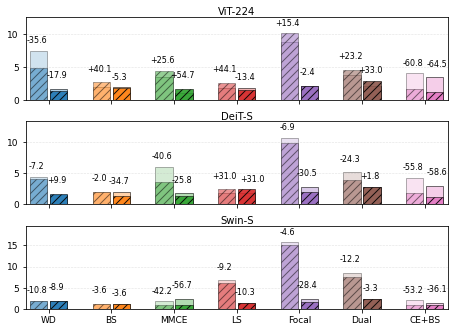

In [51]:

c10_rows = [
    ("ViT$_{224}$", "Baseline",
     [7.39, "1.68(1.30)",
      1.87, "1.87(1.00)",
      3.47, "1.06(1.10)",
      1.79, "1.79(1.00)",
      8.70, "2.11(0.70)",
      3.71, "2.15(0.90)",
      3.98, "3.41(1.40)"]),

    ("ViT$_{224}$", "CalAttn (Ours)",
     [4.76, "1.38(1.20)",
      2.62, "1.77(1.10)",
      4.36, "1.64(1.20)",
      2.58, "1.55(0.90)",
      10.04, "2.06(0.70)",
      4.57, "2.86(0.90)",
      1.56, "1.21(1.10)"]),

    ("DeiT-small", "Baseline",
     [4.42, "1.52(1.20)",
      2.02, "2.02(1.00)",
      6.01, "1.78(1.20)",
      1.84, "1.84(1.00)",
      10.65, "2.79(0.70)",
      5.11, "2.79(0.80)",
      4.25, "2.95(1.30)"]),

    ("DeiT-small", "CalAttn (Ours)",
     [4.10, "1.67(1.10)",
      1.98, "1.32(1.10)",
      3.57, "1.32(1.10)",
      2.41, "2.41(1.00)",
      9.91, "1.94(0.70)",
      3.87, "2.84(0.90)",
      1.88, "1.22(1.10)"]),

    ("Swin-small", "Baseline",
     [1.95, "1.91(0.90)",
      1.12, "1.12(1.00)",
      1.73, "2.31(0.90)",
      6.71, "1.45(0.80)",
      15.70, "2.32(0.60)",
      8.54, "2.40(0.70)",
      2.01, "1.47(1.20)"]),

    ("Swin-small", "CalAttn (Ours)",
     [1.74, "1.74(1.00)",
      1.08, "1.08(1.00)",
      1.00, "1.00(1.00)",
      6.09, "1.30(0.80)",
      14.97, "1.66(0.60)",
      7.50, "2.32(0.80)",
      0.94, "0.94(1.00)"]),
]
df10 = build_df(c10_rows)

plot_3arches_compact_onelegend(
    df10,
    outfile="../../outputs/plotSave/cifar10_3arches_compact_onelegend_better.png",
    metric_name="ECE",
    title=None,
    # tighter gaps between losses:
    step=0.88,
    # geometry (increase dx a bit if labels still feel tight):
    dx_frac=0.16,
    w_frac=0.28,
    # larger fonts:
    fig_size=(6.2, 4.5),
    delta_font=8,
    tick_font=9,
    title_font=10,
)

In [53]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def build_single_row_legend(methods, method_colors,
                            method_labels=None,
                            pre_alpha=0.50,
                            post_alpha=0.90,
                            hatch="///"):
    """
    Build a ONE-ROW legend:
      - Method/color items (one per loss)
      - Pre-T / Post-T (alpha semantics)
      - Baseline / CalAttn (fill vs hatch semantics)
    Returns (handles, labels).
    """
    # Method-color handles
    handles = []
    labels = []

    for m in methods:
        lab = method_labels[m] if method_labels is not None else m
        handles.append(Patch(facecolor=method_colors[m], edgecolor="black"))
        labels.append(lab)

    # Stage semantics (alpha)
    handles += [
        Patch(facecolor="gray", edgecolor="black", alpha=pre_alpha),
        Patch(facecolor="gray", edgecolor="black", alpha=post_alpha),
    ]
    labels += [
        "Pre-T (lower alpha)",
        "Post-T (higher alpha)",
    ]

    # Variant semantics (baseline vs calattn)
    handles += [
        Patch(facecolor="white", edgecolor="black", hatch=""),
        Patch(facecolor="white", edgecolor="black", hatch=hatch),
    ]
    labels += [
        "Baseline (lighter fill)",
        "CalAttn (hatch)",
    ]

    return handles, labels


def demo_one_row_legend_png(outfile="one_row_legend.png"):
    # Example inputs (replace with your real ones)
    methods = ["WD", "Brier", "MMCE", "LS", "Focal", "Dual", "CE+BS"]
    tab10 = plt.get_cmap("tab10").colors
    method_colors = {m: tab10[i % len(tab10)] for i, m in enumerate(methods)}

    # Optional: map method keys to displayed labels (can be same as methods)
    method_labels = {m: m for m in methods}

    handles, labels = build_single_row_legend(
        methods=methods,
        method_colors=method_colors,
        method_labels=method_labels,
        pre_alpha=0.50,
        post_alpha=0.90,
        hatch="///"
    )

    fig = plt.figure(figsize=(12.5, 1.4))
    ax = fig.add_subplot(111)
    ax.axis("off")

    leg = fig.legend(
        handles=handles,
        labels=labels,
        loc="center",
        ncol=len(handles),          # ONE ROW
        frameon=True,               # with frame
        fancybox=False,
        edgecolor="black",
        fontsize=10,
        handlelength=1.1,
        handletextpad=0.45,
        columnspacing=0.9,
        borderpad=0.35
    )
    leg.get_frame().set_linewidth(0.9)

    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.close(fig)


if __name__ == "__main__":
    demo_one_row_legend_png("../../outputs/plotSave/one_row_legend.png")


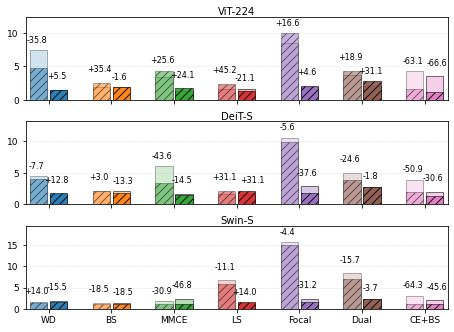

In [54]:
# smECE — CIFAR-10
c10_rows = [
    ("ViT$_{224}$", "Baseline",
     [7.40, "1.46(1.30)",
      1.89, "1.89(1.00)",
      3.47, "1.37(1.10)",
      1.66, "1.66(1.00)",
      8.53, "1.97(0.70)",
      3.66, "2.12(0.90)",
      4.26, "3.53(1.40)"]),

    ("ViT$_{224}$", "CalAttn (Ours)",
     [4.75, "1.54(1.20)",
      2.56, "1.86(1.10)",
      4.36, "1.70(1.20)",
      2.41, "1.31(0.90)",
      9.95, "2.06(0.70)",
      4.35, "2.78(0.90)",
      1.57, "1.18(1.10)"]),

    ("DeiT-small", "Baseline",
     [4.41, "1.56(1.20)",
      2.03, "2.03(1.00)",
      6.01, "1.65(1.20)",
      1.64, "1.64(1.00)",
      10.49, "2.87(0.70)",
      5.00, "2.79(0.80)",
      3.85, "1.96(1.30)"]),

    ("DeiT-small", "CalAttn (Ours)",
     [4.07, "1.76(1.10)",
      2.09, "1.76(1.10)",
      3.39, "1.41(1.10)",
      2.15, "2.15(1.00)",
      9.90, "1.79(0.70)",
      3.77, "2.74(0.90)",
      1.89, "1.36(1.10)"]),

    ("Swin-small", "Baseline",
     [1.43, "1.93(0.90)",
      1.46, "1.46(1.00)",
      1.78, "2.31(0.90)",
      6.68, "1.36(0.80)",
      15.63, "2.34(0.60)",
      8.40, "2.41(0.70)",
      3.11, "2.04(1.20)"]),

    ("Swin-small", "CalAttn (Ours)",
     [1.63, "1.63(1.00)",
      1.19, "1.19(1.00)",
      1.23, "1.23(1.00)",
      5.94, "1.55(0.80)",
      14.94, "1.61(0.60)",
      7.08, "2.32(0.80)",
      1.11, "1.11(1.00)"]),
]

df10sm = build_df(c10_rows)

plot_3arches_compact_onelegend(
    df10sm,
    outfile="../../outputs/plotSave/smECE_cifar10_3arches_compact_onelegend_better.png",
    metric_name="smECE",
    title=None,
    # tighter gaps between losses:
    step=0.88,
    # geometry (increase dx a bit if labels still feel tight):
    dx_frac=0.16,
    w_frac=0.28,
    # larger fonts:
    fig_size=(6.2, 4.5),
    delta_font=8,
    tick_font=9,
    title_font=10,
)


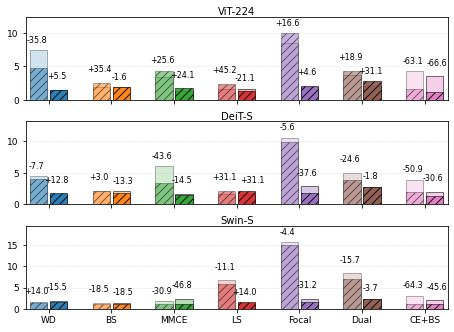

In [55]:
# smECE — CIFAR-100
c100_rows = [
    ("ViT$_{224}$", "Baseline",
     [13.07, "3.32(1.30)",
      2.62, "2.25(1.10)",
      11.51, "2.25(1.30)",
      3.77, "2.17(1.10)",
      5.13, "3.20(1.10)",
      3.43, "3.43(1.00)",
      6.27, "2.25(1.50)"]),

    ("ViT$_{224}$", "CalAttn (Ours)",
     [8.24, "1.92(1.20)",
      1.93, "2.30(1.10)",
      9.04, "2.16(1.20)",
      1.97, "1.97(1.00)",
      2.64, "2.64(1.00)",
      3.66, "1.96(1.10)",
      4.00, "1.49(1.10)"]),

    ("DeiT-small", "Baseline",
     [7.45, "3.48(1.10)",
      2.13, "2.13(1.00)",
      7.88, "2.34(1.20)",
      1.72, "1.72(1.00)",
      3.01, "3.01(1.00)",
      1.91, "1.91(1.00)",
      5.13, "2.06(1.40)"]),

    ("DeiT-small", "CalAttn (Ours)",
     [6.87, "1.59(1.20)",
      2.13, "2.05(1.10)",
      6.51, "1.28(1.20)",
      1.61, "1.61(1.00)",
      3.08, "3.08(1.00)",
      3.05, "2.16(1.10)",
      4.37, "1.17(1.10)"]),

    ("Swin-small", "Baseline",
     [3.44, "2.44(0.90)",
      2.55, "2.55(1.00)",
      3.37, "2.66(0.90)",
      8.76, "2.35(0.80)",
      10.55, "2.42(0.80)",
      8.17, "3.04(0.80)",
      3.23, "2.45(1.20)"]),

    ("Swin-small", "CalAttn (Ours)",
     [1.99, "1.99(1.00)",
      3.02, "1.92(1.10)",
      1.76, "1.76(1.00)",
      6.48, "2.56(0.90)",
      5.99, "2.99(0.90)",
      3.76, "2.92(0.90)",
      1.64, "1.64(1.00)"]),
]

df100sm = build_df(c100_rows)

plot_3arches_compact_onelegend(
    df10sm,
    outfile="../../outputs/plotSave/smECE_cifar100_3arches_compact_onelegend_better.png",
    metric_name="smECE",
    title=None,
    # tighter gaps between losses:
    step=0.88,
    # geometry (increase dx a bit if labels still feel tight):
    dx_frac=0.16,
    w_frac=0.28,
    # larger fonts:
    fig_size=(6.2, 4.5),
    delta_font=8,
    tick_font=9,
    title_font=10,
)


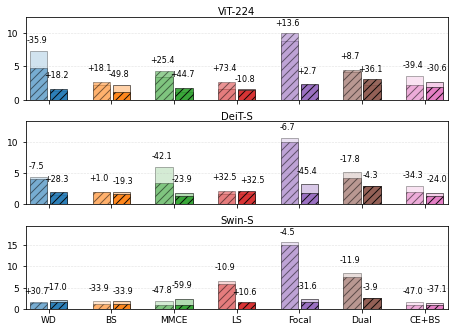

In [58]:
# adaECE — CIFAR-10
c10_rows = [
    ("ViT$_{224}$", "Baseline",
     [7.39, "1.37(1.30)",
      2.27, "2.27(1.00)",
      3.47, "1.23(1.10)",
      1.58, "1.58(1.00)",
      8.77, "2.24(0.70)",
      4.16, "2.27(0.90)",
      3.58, "2.68(1.40)"]),

    ("ViT$_{224}$", "CalAttn (Ours)",
     [4.74, "1.62(1.20)",
      2.68, "1.14(1.10)",
      4.35, "1.78(1.20)",
      2.74, "1.41(0.90)",
      9.96, "2.30(0.70)",
      4.52, "3.09(0.90)",
      2.17, "1.86(1.10)"]),

    ("DeiT-small", "Baseline",
     [4.41, "1.52(1.20)",
      1.97, "1.97(1.00)",
      6.01, "1.84(1.20)",
      1.66, "1.66(1.00)",
      10.62, "3.17(0.70)",
      5.11, "3.00(0.80)",
      2.97, "1.83(1.30)"]),

    ("DeiT-small", "CalAttn (Ours)",
     [4.08, "1.95(1.10)",
      1.99, "1.59(1.10)",
      3.48, "1.40(1.10)",
      2.20, "2.20(1.00)",
      9.91, "1.73(0.70)",
      4.20, "2.87(0.90)",
      1.95, "1.39(1.10)"]),

    ("Swin-small", "Baseline",
     [1.27, "2.00(0.90)",
      1.77, "1.77(1.00)",
      1.86, "2.42(0.90)",
      6.67, "1.41(0.80)",
      15.69, "2.28(0.60)",
      8.40, "2.57(0.70)",
      1.66, "1.40(1.20)"]),

    ("Swin-small", "CalAttn (Ours)",
     [1.66, "1.66(1.00)",
      1.17, "1.17(1.00)",
      0.97, "0.97(1.00)",
      5.94, "1.56(0.80)",
      14.98, "1.56(0.60)",
      7.40, "2.47(0.80)",
      0.88, "0.88(1.00)"]),
]


df10ada = build_df(c10_rows)

plot_3arches_compact_onelegend(
    df10ada,
    outfile="../../outputs/plotSave/adaECE_cifar10_3arches_compact_onelegend_better.png",
    metric_name="AdaECE",
    title=None,
    # tighter gaps between losses:
    step=0.88,
    # geometry (increase dx a bit if labels still feel tight):
    dx_frac=0.16,
    w_frac=0.28,
    # larger fonts:
    fig_size=(6.2, 4.5),
    delta_font=8,
    tick_font=9,
    title_font=10,
)


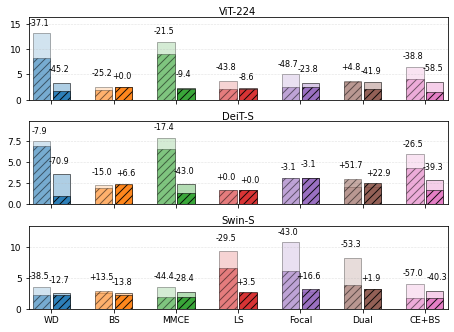

In [57]:
# adaECE — CIFAR-100
c100_rows = [
    ("ViT$_{224}$", "Baseline",
     [13.11, "3.34(1.30)",
      2.58, "2.56(1.10)",
      11.51, "2.33(1.30)",
      3.77, "2.32(1.10)",
      5.07, "3.41(1.10)",
      3.56, "3.56(1.00)",
      6.55, "3.54(1.50)"]),

    ("ViT$_{224}$", "CalAttn (Ours)",
     [8.25, "1.83(1.20)",
      1.93, "2.56(1.10)",
      9.04, "2.11(1.20)",
      2.12, "2.12(1.00)",
      2.60, "2.60(1.00)",
      3.73, "2.07(1.10)",
      4.01, "1.47(1.10)"]),

    ("DeiT-small", "Baseline",
     [7.46, "3.57(1.10)",
      2.26, "2.26(1.00)",
      7.88, "2.35(1.20)",
      1.67, "1.67(1.00)",
      3.18, "3.18(1.00)",
      2.01, "2.01(1.00)",
      5.93, "2.85(1.40)"]),

    ("DeiT-small", "CalAttn (Ours)",
     [6.87, "1.04(1.20)",
      1.92, "2.41(1.10)",
      6.51, "1.34(1.20)",
      1.67, "1.67(1.00)",
      3.08, "3.08(1.00)",
      3.05, "2.47(1.10)",
      4.36, "1.73(1.10)"]),

    ("Swin-small", "Baseline",
     [3.58, "2.52(0.90)",
      2.60, "2.60(1.00)",
      3.54, "2.75(0.90)",
      9.29, "2.56(0.80)",
      10.71, "2.71(0.80)",
      8.24, "3.16(0.80)",
      4.07, "2.93(1.20)"]),

    ("Swin-small", "CalAttn (Ours)",
     [2.20, "2.20(1.00)",
      2.95, "2.24(1.10)",
      1.97, "1.97(1.00)",
      6.55, "2.65(0.90)",
      6.10, "3.16(0.90)",
      3.85, "3.22(0.90)",
      1.75, "1.75(1.00)"]),
]

df100ada = build_df(c100_rows)

plot_3arches_compact_onelegend(
    df100ada,
    outfile="../../outputs/plotSave/adaECE_cifar100_3arches_compact_onelegend_better.png",
    metric_name="AdaECE",
    title=None,
    # tighter gaps between losses:
    step=0.88,
    # geometry (increase dx a bit if labels still feel tight):
    dx_frac=0.16,
    w_frac=0.28,
    # larger fonts:
    fig_size=(6.2, 4.5),
    delta_font=8,
    tick_font=9,
    title_font=10,
)
